# Predcition of Hospital Admission Related to Infections

In this notebook, we develop a Cox proportional hazard regression model to predict the risk of hospital admission for common infections including urinary tract infection (ot_externa), upper respiratory tract infection (ot_externa), lower respiratory tract infection (ot_externa), ot_externa, otitis media or middle ear infection (ot media), and ear infection or otitis externa (ot externa).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
import sys
from contextlib import redirect_stdout
# %matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [47]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
#    a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [4]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [5]:
def ConvertColumns(InfectionKey, NumSets):
    for i in range(1, NumSets+1):        
        arrayKey1 = 'admitted_'+InfectionKey+'_date_'+str(i)
        #arrayKey2 = InfectionKey+'_date_'+str(i)
        data[arrayKey1] = data[arrayKey1].astype('datetime64[ns]')

In [6]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [ ]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'hx_hosp', 'CCI', 'died_date', 'deregistered_date',  #'meds_nonabs', 
                   'gp_count_'+str(i), 'antibacterial_brit_'+str(i), 
                   'ot_externa_date_'+str(i), 'ot_externa_ab_date_'+str(i),
                   'incdt_ot_externa_date_'+str(i), 'admitted_ot_externa_date_'+str(i), 'sgss_gp_cov_ot_externa_date_'+str(i)]]
    
    #drop rows with no ot_externa reord
    datum = datum[datum['ot_externa_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with ot_externa_i
    datum = datum[datum['sgss_gp_cov_ot_externa_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'ot_externa_date_'+str(i): 'ot_externa_date', 'ot_externa_ab_date_'+str(i): 'ot_externa_ab_date',
                           'gp_count_'+str(i): 'gp_count', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_ot_externa_date_'+str(i): 'incdt_ot_externa_date', #'prevl_ot_externa_date_'+str(i): 'prevl_ot_externa_date',
                           'admitted_ot_externa_date_'+str(i): 'admitted_ot_externa_date',
                           'sgss_gp_cov_ot_externa_date_'+str(i): 'sgss_gp_cov_ot_externa_date'},
                inplace=True)
    
    return datum

## 1- Data Preparation

In [7]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_ot_externa.csv.gz')
data.shape

(200000, 79)

In [ ]:
# save model outputs
a = open("../output/hospitalisation_prediction_ot_externa/data_ot_externa_record_cph_ot_externa.txt", "w")
a.write("")
a.writelines(['data_ot_externa_1 #with a record, #with no record: %.0f' % (data['ot_externa_date_1'].notna().sum()), ', %.0f' % (data['ot_externa_date_1'].isna().sum()),
              '\ndata_ot_externa_2 #with a record, #with no record: %.0f' % (data['ot_externa_date_2'].notna().sum()), ', %.0f' % (data['ot_externa_date_2'].isna().sum()),
              '\ndata_ot_externa_3 #with a record, #with no record: %.0f' % (data['ot_externa_date_3'].notna().sum()), ', %.0f' % (data['ot_externa_date_3'].isna().sum()),
              '\ndata_ot_externa_4 #with a record, #with no record: %.0f' % (data['ot_externa_date_4'].notna().sum()), ', %.0f' % (data['ot_externa_date_4'].isna().sum()),
              '\ndata_ot_externa_5 #with a record, #with no record: %.0f' % (data['ot_externa_date_5'].notna().sum()), ', %.0f' % (data['ot_externa_date_5'].isna().sum()),
              '\ndata_ot_externa_6 #with a record, #with no record: %.0f' % (data['ot_externa_date_6'].notna().sum()), ', %.0f' % (data['ot_externa_date_6'].isna().sum()),
              '\ndata_ot_externa_7 #with a record, #with no record: %.0f' % (data['ot_externa_date_7'].notna().sum()), ', %.0f' % (data['ot_externa_date_7'].isna().sum()),
              '\ndata_ot_externa_8 #with a record, #with no record: %.0f' % (data['ot_externa_date_8'].notna().sum()), ', %.0f' % (data['ot_externa_date_8'].isna().sum()),
              '\ndata_ot_externa_9 #with a record, #with no record: %.0f' % (data['ot_externa_date_9'].notna().sum()), ', %.0f' % (data['ot_externa_date_9'].isna().sum()),
              '\ndata_ot_externa_10 #with a record, #with no record: %.0f' % (data['ot_externa_date_10'].notna().sum()), ', %.0f' % (data['ot_externa_date_10'].isna().sum()),
              '\ndata_ot_externa_11 #with a record, #with no record: %.0f' % (data['ot_externa_date_11'].notna().sum()), ', %.0f' % (data['ot_externa_date_11'].isna().sum()),
              '\ndata_ot_externa_12 #with a record, #with no record: %.0f' % (data['ot_externa_date_12'].notna().sum()), ', %.0f' % (data['ot_externa_date_12'].isna().sum()),
              '\ndata_ot_externa_13 #with a record, #with no record: %.0f' % (data['ot_externa_date_13'].notna().sum()), ', %.0f' % (data['ot_externa_date_13'].isna().sum()),
              '\ndata_ot_externa_14 #with a record, #with no record: %.0f' % (data['ot_externa_date_14'].notna().sum()), ', %.0f' % (data['ot_externa_date_14'].isna().sum()),
              '\ndata_ot_externa_15 #with a record, #with no record: %.0f' % (data['ot_externa_date_15'].notna().sum()), ', %.0f' % (data['ot_externa_date_15'].isna().sum()),
              '\ndata_ot_externa_16 #with a record, #with no record: %.0f' % (data['ot_externa_date_16'].notna().sum()), ', %.0f' % (data['ot_externa_date_16'].isna().sum()),
              '\ndata_ot_externa_17 #with a record, #with no record: %.0f' % (data['ot_externa_date_17'].notna().sum()), ', %.0f' % (data['ot_externa_date_17'].isna().sum()),
              '\ndata_ot_externa_18 #with a record, #with no record: %.0f' % (data['ot_externa_date_18'].notna().sum()), ', %.0f' % (data['ot_externa_date_18'].isna().sum()),
              ])

In [8]:
data.describe(include='all')

,deregistered_date,died_date,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,admitted_date,ot_externa_date_1,ot_externa_date_2,...,incdt_ot_externa_date_4,sgss_gp_cov_ot_externa_date_1,sgss_gp_cov_ot_externa_date_2,sgss_gp_cov_ot_externa_date_3,sgss_gp_cov_ot_externa_date_4,ot_externa_ab_count_1,ot_externa_ab_count_2,ot_externa_ab_count_3,ot_externa_ab_count_4,patient_id
count,10000,20000,150000,20000,20000,20000,20000,60000,20000,20000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05
unique,1268,711,42,42,42,13,13,1268,1268,1268,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2019-03-02,2022-06-19,2022-03,2020-12,2020-05,2018-05,2018-03,2019-02-07,2020-01-03,2019-02-15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,21,178,3830,546,567,1730,1732,69,29,34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.898730,0.899385,0.902160,0.899405,1.003211e+06
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300001,0.300001,0.300001,0.300001,0.300001,1.856435,1.859311,1.863356,1.858576,5.765303e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.053385e+05
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.004994e+06
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500932e+06


### 1-2- Additional variables
#### 1-2-1- Calculating Charlson Comorbidity Index
Based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [9]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')
# col18 = data.columns.get_loc('age')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

1.0     37165
0.0     37028
2.0     33127
3.0     24815
4.0     14611
6.0     12311
7.0      9954
5.0      8348
8.0      8177
9.0      5709
10.0     3335
11.0     1834
12.0     1399
13.0      822
14.0      592
15.0      377
16.0      208
17.0      100
18.0       49
19.0       25
20.0       10
21.0        3
22.0        1
Name: CCI, dtype: int64

#### 1-2-2- Calculating all meds except abs

In [1]:
# #generate meds_noabs in the one month before
# data['meds_nonabs'] = data['all_meds'] - data['antibacterial_brit']

# # assign zero for any row with negative values which could be the case because of using dummy data and/or the inconsistency of the two codelists of all_meds and antibacterial_brit
# data['meds_nonabs'][data['meds_nonabs'] < 0] = 0

# data['meds_nonabs'].value_counts()
# # data[['all_meds_one_month', 'antibacterial_brit_one_month', 'meds_nonabs']]

## 2- Data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- Gathering data

In [14]:
#read 12 ot_externas and concatenate them 
data_ot_externa_1 = proc_infec_data(data,1)
data_ot_externa_2 = proc_infec_data(data,2)
data_ot_externa_3 = proc_infec_data(data,3)
data_ot_externa_4 = proc_infec_data(data,4)
data_ot_externa_5 = proc_infec_data(data,5)
data_ot_externa_6 = proc_infec_data(data,6)
data_ot_externa_7 = proc_infec_data(data,7)
data_ot_externa_8 = proc_infec_data(data,8)
data_ot_externa_9 = proc_infec_data(data,9)
data_ot_externa_10 = proc_infec_data(data,10)
data_ot_externa_11 = proc_infec_data(data,11)
data_ot_externa_12 = proc_infec_data(data,12)

data_ot_externa = pd.concat([data_ot_externa_1, data_ot_externa_2, data_ot_externa_3, data_ot_externa_4, data_ot_externa_5, data_ot_externa_6, data_ot_externa_7, data_ot_externa_8, data_ot_externa_9, data_ot_externa_10, data_ot_externa_11, data_ot_externa_12])
data_ot_externa.reset_index(inplace=True, drop=True)
data_ot_externa.shape

(1720, 22)

### 2-2- Add season, event, and duration variables
#### Season

In [16]:
# convert data types
data_ot_externa['ot_externa_date'] = data_ot_externa['ot_externa_date'].astype('datetime64[ns]')
# data_ot_externa['gp_cons_ot_externa'] = data_ot_externa['gp_cons_ot_externa'].astype('datetime64[ns]')
data_ot_externa['admitted_ot_externa_date'] = data_ot_externa['admitted_ot_externa_date'].astype('datetime64[ns]')
data_ot_externa.died_date = data_ot_externa.died_date.astype('datetime64[ns]')
data_ot_externa.deregistered_date = data_ot_externa.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_ot_externa['date'] = data_ot_externa['ot_externa_date'] #gp_cons_ot_externa
data_ot_externa['date'] = data_ot_externa['date'].dt.strftime('%Y-%m')
data_ot_externa.shape

(7072, 23)

In [17]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_ot_externa with today's date in year and month
data_ot_externa = data_ot_externa[data_ot_externa['date'] != today_date_y_m]

#get 2 months before today's date in year and month 
last_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_month_date_y_m = last_month_date_y_m.strftime('%Y-%m')
#drop any record of data with 1 month before today's date in year and month
data_ot_externa = data_ot_externa[data_ot_externa['date'] != last_month_date_y_m]

#add a variable called season based on the month of ot_externa records
data_ot_externa['season'] = np.nan
data_ot_externa['date_month'] = pd.DatetimeIndex(data_ot_externa['date']).month

conditions = [
    (data_ot_externa['date_month'] >= 3) & (data_ot_externa['date_month'] <= 5),
    (data_ot_externa['date_month'] >= 6) & (data_ot_externa['date_month'] <= 8),
    (data_ot_externa['date_month'] >= 9) & (data_ot_externa['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_ot_externa['season'] = np.select(conditions, choices, default='winter')

data_ot_externa['season'].value_counts()

spring    1925
winter    1807
summer    1536
autumn    1520
Name: season, dtype: int64

In [ ]:
# data_ot_externa = data_ot_externa[data_ot_externa['date'] <= '2019-12']
# data_ot_externa = data_ot_externa[(data_ot_externa['date'] >= '2020-03') & (data_ot_externa['date']<= '2021-03')]
# data_ot_externa = data_ot_externa[data_ot_externa['date'] >= '2021-04']
data_ot_externa.shape

#### Adding event and duration columns

In [18]:
#scenario 1
#not hosped (nothing happened)
#data_ot_externa = data_ot_externa[data_ot_externa['admitted_ot_externa_date'].notnull()]
data_ot_externa.loc[data_ot_externa['admitted_ot_externa_date'].isnull(), 'event_ot_externa_admitted'] = 0
data_ot_externa['event_ot_externa_admitted'].value_counts()

0.0    4783
Name: event_ot_externa_admitted, dtype: int64

In [19]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_ot_externa['delta_ot_externa_admitted'] = (data_ot_externa['admitted_ot_externa_date'] - data_ot_externa['ot_externa_date']).dt.days
data_ot_externa['delta_ot_externa_admitted'] = (data_ot_externa['admitted_ot_externa_date'] - data_ot_externa['ot_externa_date']).dt.days #gp_cons_ot_externa
data_ot_externa.loc[((data_ot_externa['delta_ot_externa_admitted'] >= 0) & (data_ot_externa['delta_ot_externa_admitted'] <= 30)), 'event_ot_externa_admitted'] = 1
# data_ot_externa['event_ot_externa_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before ot_externa consultation, i.e. negative value for delta_ot_externa_admitted
data_ot_externa = data_ot_externa[~(data_ot_externa['delta_ot_externa_admitted'] < 0)]
data_ot_externa['delta_ot_externa_admitted'].value_counts()

60.0     6
84.0     6
369.0    5
162.0    5
161.0    5
        ..
48.0     1
947.0    1
854.0    1
691.0    1
776.0    1
Name: delta_ot_externa_admitted, Length: 642, dtype: int64

In [20]:
#scenario 3
#censor died patients
data_ot_externa['delta_admitted_died'] = (data_ot_externa['died_date'] - data_ot_externa['admitted_ot_externa_date']).dt.days
data_ot_externa.loc[data_ot_externa['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_ot_externa.loc[data_ot_externa['delta_admitted_died'] >= 0, 'event_ot_externa_admitted'] = 0
data_ot_externa.loc[((data_ot_externa['delta_admitted_died'] >= 0) & (data_ot_externa['delta_admitted_died'] <= 30)), 'event_ot_externa_admitted'] = 0
# data_ot_externa['event_ot_externa_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_ot_externa['delta_admitted_deregistered'] = (data_ot_externa['deregistered_date'] - data_ot_externa['admitted_ot_externa_date']).dt.days
data_ot_externa.loc[data_ot_externa['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_ot_externa.loc[data_ot_externa['delta_admitted_deregistered'] >= 0, 'event_ot_externa_admitted'] = 0
data_ot_externa.loc[((data_ot_externa['delta_admitted_deregistered'] > 0) & (data_ot_externa['delta_admitted_deregistered'] <= 30)), 'event_ot_externa_admitted'] = 0
# data_ot_externa['event_ot_externa_admitted'].value_counts()

#agg scenario 3s
data_ot_externa['delta_admitted_died_deregistered'] = data_ot_externa['delta_admitted_deregistered'].combine_first(data_ot_externa['delta_admitted_died'])
data_ot_externa.loc[data_ot_externa['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_ot_externa['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

5727

In [21]:
#scenario 1
#any other patients (nothing happened)
data_ot_externa['event_ot_externa_admitted'] = data_ot_externa['event_ot_externa_admitted'].replace(np.NaN, 0)
data_ot_externa['event_ot_externa_admitted'].value_counts()

0.0    5790
1.0      58
Name: event_ot_externa_admitted, dtype: int64

In [22]:
#assign values for duration column
data_ot_externa['duration_ot_externa_admitted'] = data_ot_externa['delta_ot_externa_admitted'].combine_first(data_ot_externa['delta_admitted_died_deregistered'])
data_ot_externa['duration_ot_externa_admitted'] = data_ot_externa['duration_ot_externa_admitted'].replace(np.NaN, 30)
data_ot_externa.loc[(data_ot_externa['duration_ot_externa_admitted'] > 30), 'duration_ot_externa_admitted'] = 30
data_ot_externa['duration_ot_externa_admitted'].value_counts()

30.0    5791
22.0       5
19.0       4
18.0       4
29.0       4
16.0       3
11.0       3
17.0       3
14.0       3
25.0       3
6.0        3
0.0        2
1.0        2
20.0       2
8.0        2
9.0        2
23.0       2
24.0       2
26.0       2
28.0       1
21.0       1
27.0       1
12.0       1
3.0        1
7.0        1
Name: duration_ot_externa_admitted, dtype: int64

In [23]:
# give value 1 to event_ot_externa_admitted if duration_ot_externa_admitted is greater or equal to 0 and less than 30
data_ot_externa.loc[((data_ot_externa['duration_ot_externa_admitted'] >= 0) & (data_ot_externa['duration_ot_externa_admitted'] < 30)), 'event_ot_externa_admitted'] = 1
data_ot_externa['event_ot_externa_admitted'].value_counts()

0.0    5790
1.0      58
Name: event_ot_externa_admitted, dtype: int64

In [24]:
#drop any rows with value 0 in duration column
data_ot_externa = data_ot_externa[~(data_ot_externa['duration_ot_externa_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_ot_externa.loc[((data_ot_externa['delta_ot_externa_admitted'] > 0) & (data_ot_externa['delta_ot_externa_admitted'] < 30)), 'event_ot_externa_admitted'] = 1

In [25]:
# data_ot_externa[data_ot_externa['duration_ot_externa_admitted']==0][['delta_ot_externa_admitted', 'ot_externa_date', 'gp_cons_ot_externa', 'admitted_ot_externa_date', 'delta_ot_externa_admitted', 'delta_admitted_died_deregistered', 'event_ot_externa_admitted', 'duration_ot_externa_admitted']]
# data_ot_externa.loc[151:200, ['event_ot_externa_admitted', 'duration_ot_externa_admitted']]
# data_ot_externa.loc[201:250, ['event_ot_externa_admitted', 'duration_ot_externa_admitted']].sort_values(by=['duration_ot_externa_admitted'])
data_ot_externa[['event_ot_externa_admitted', 'duration_ot_externa_admitted']].sort_values(by=['duration_ot_externa_admitted'])

,event_ot_externa_admitted,duration_ot_externa_admitted
288,1.0,1.0
593,1.0,1.0
6640,1.0,3.0
5629,1.0,6.0
1156,1.0,6.0
...,...,...
2377,0.0,30.0
2376,0.0,30.0
2375,0.0,30.0
2372,0.0,30.0


### 2-3- Dealing with uninteresting and missing values

In [26]:
# prep before plot
data_ot_externa['age'][data_ot_externa['age'] < 0] = np.nan
# drop anybody with age less than 18
data_ot_externa = data_ot_externa[~(data_ot_externa['age'] < 18)]  
print(f'Min age: {data_ot_externa.age.min()}')

## remove died cases
#data_ot_externa.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_ot_externa['bmi'][data_ot_externa['bmi'] < 10] = 0
# replace 0s with nans
data_ot_externa['bmi'] = data_ot_externa['bmi'].replace({0:np.nan})

# remove cases with negative gp_count
data_ot_externa['gp_count'][data_ot_externa['gp_count'] < 0] = np.nan

# remove cases with negative antibacterial_brit
data_ot_externa['antibacterial_brit'][data_ot_externa['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [27]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_ot_externa = data_ot_externa.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_ot_externa = data_ot_externa.replace({"smoking_status": dict_smoking})

In [28]:
if ('region' in data_ot_externa.columns) and (data_ot_externa['region'].isnull().sum() > 0):
    # drop region value missing
    # data_ot_externa['region_imp'] = data_ot_externa['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_ot_externa.region.isnull().sum()}')
    data_ot_externa = data_ot_externa[data_ot_externa['region'].notna()]

print(f'Cound of missing values in variable region: {data_ot_externa.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_ot_externa.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      955
Yorkshire and The Humber    474
North West                  473
East                        470
South West                  468
West Midlands               466
East Midlands               442
North East                  440
South East                  438
Name: region, dtype: int64


In [29]:
if ('gp_count' in data_ot_externa.columns) and (data_ot_externa['gp_count'].isnull().sum() > 0):
    print(f'Cound of missing values in variable gp_count before changing NAN to zeros: {data_ot_externa.gp_count.isnull().sum()}')
    print(f'Mean of gp_count values before changing NAN to zeros: {data_ot_externa.gp_count.mean():.3f}')
    data_ot_externa['gp_count'] = data_ot_externa['gp_count'].fillna(0)
    # data_ot_externa['gp_count'] = data_ot_externa['gp_count'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable gp_count after changing NANs to zeros: {data_ot_externa.gp_count.isnull().sum()}')
print(f'Mean of gp_count values after changing NANs to zeros: {data_ot_externa.gp_count.mean():.3f}')

Cound of missing values in variable gp_count before changing NAN to zeros: 25
Mean of gp_count values before changing NAN to zeros: 3.344

Cound of missing values in variable gp_count after changing NANs to zeros: 0
Mean of gp_count values after changing NANs to zeros: 3.326


In [30]:
if ('antibacterial_brit' in data_ot_externa.columns) and (data_ot_externa['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_ot_externa.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_ot_externa.antibacterial_brit.mean():.3f}')
    data_ot_externa['antibacterial_brit'] = data_ot_externa['antibacterial_brit'].fillna(0)
    # data_ot_externa['antibacterial_brit'] = data_ot_externa['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_ot_externa.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_ot_externa.antibacterial_brit.mean():.3f}')


Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.251


In [2]:
# if ('meds_nonabs' in data_ot_externa.columns) and (data_ot_externa['meds_nonabs'].isnull().sum() > 0):
#     print(f'Cound of missing values in variable meds_nonabs before changing NANs to zeros: {data_ot_externa.meds_nonabs.isnull().sum()}')
#     print(f'Mean of meds_nonabs values before changing NAN to zeros: {data_ot_externa.meds_nonabs.mean():.3f}')
#     data_ot_externa['meds_nonabs'] = data_ot_externa['meds_nonabs'].fillna(0)
#     # data_ot_externa['meds_nonabs'] = data_ot_externa['meds_nonabs'].replace({'0':np.nan, 0:np.nan})

# print(f'\nCound of missing values in variable meds_nonabs after changing NANs to zeros: {data_ot_externa.meds_nonabs.isnull().sum()}')
# print(f'Mean of meds_nonabs values after changing NANs to zeros: {data_ot_externa.meds_nonabs.mean():.3f}')

In [32]:
if ('hx_hosp' in data_ot_externa.columns) and (data_ot_externa['hx_hosp'].isnull().sum() > 0):
    print(f'Cound of missing values in variable hx_hosp before changing NANs to zeros: {data_ot_externa.hx_hosp.isnull().sum()}')
    print(f'Mean of hx_hosp values before changing NAN to zeros: {data_ot_externa.hx_hosp.mean():.3f}')
    data_ot_externa['hx_hosp'] = data_ot_externa['hx_hosp'].fillna(0)
    # data_ot_externa['hx_hosp'] = data_ot_externa['hx_hosp'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable hx_hosp after changing NANs to zeros: {data_ot_externa.hx_hosp.isnull().sum()}')
print(f'Mean of hx_hosp values after changing NANs to zeros: {data_ot_externa.hx_hosp.mean():.3f}')


Cound of missing values in variable hx_hosp after changing NANs to zeros: 0
Mean of hx_hosp values after changing NANs to zeros: 0.461


In [33]:
if ('ethnicity' in data_ot_externa.columns) and (data_ot_externa['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_ot_externa.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_ot_externa.ethnicity.value_counts()}')
    # data_ot_externa['ethnicity'] = data_ot_externa['ethnicity'].astype(str)
    data_ot_externa['ethnicity'] = data_ot_externa['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_ot_externa.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_ot_externa.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 1223
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    2708
3.0     357
5.0     338
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    2708
0.0    1223
3.0     357
5.0     338
Name: ethnicity, dtype: int64


In [34]:
if ('smoking_status' in data_ot_externa.columns) and (data_ot_externa['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_ot_externa.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_ot_externa.smoking_status.value_counts()}')
    # data_ot_externa['smoking_status'] = data_ot_externa['smoking_status'].astype(str)
    data_ot_externa['smoking_status'] = data_ot_externa['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_ot_externa.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_ot_externa.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 1983
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    1795
3.0     595
2.0     253
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    1983
1.0    1795
3.0     595
2.0     253
Name: smoking_status, dtype: int64


In [35]:
if ('imd' in data_ot_externa.columns) and (data_ot_externa['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_ot_externa.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_ot_externa.imd.value_counts()}')
    # data_ot_externa['imd'] = data_ot_externa['imd'].astype(str)
    data_ot_externa['imd'] = data_ot_externa['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_ot_externa.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_ot_externa.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
4    921
5    895
2    890
1    859
3    839
0    222
Name: imd, dtype: int64


In [36]:
# data_ot_externa['bmi_cat'] = np.nan
data_ot_externa['bmi_cat'] = 5
# data_ot_externa['bmi_cat'] = data_ot_externa['bmi_cat'].astype(str)
col_bmi_cat = data_ot_externa.columns.get_loc('bmi_cat')

col_sex = data_ot_externa.columns.get_loc('sex')
col_age = data_ot_externa.columns.get_loc('age')
col_bmi = data_ot_externa.columns.get_loc('bmi')

for idx, x in enumerate(data_ot_externa['bmi_cat']):
    # if data_ot_externa.iat[idx, col_age] >= 18: # 18 or older adults
    if data_ot_externa.iat[idx, col_bmi] >= 30:
        data_ot_externa.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_ot_externa.iat[idx, col_bmi] >= 25) and (data_ot_externa.iat[idx, col_bmi] < 30):
        data_ot_externa.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_ot_externa.iat[idx, col_bmi] >= 18.5) and (data_ot_externa.iat[idx, col_bmi] < 25):
        data_ot_externa.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_ot_externa.iat[idx, col_bmi] < 18.5:
        data_ot_externa.iat[idx, col_bmi_cat] = 4 #'Underweight'
    #if data_ot_externa.iat[idx, col_age] < 18: # drop anyone less than 18 year old children
    #     if data_ot_externa.iat[idx, col_sex] == 0:
    #         for i in range(2, 18):         
    #             if data_ot_externa.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 98):
    #                 data_ot_externa.iat[idx, col_bmi_cat] = 1 #'Obese'
    #             if data_ot_externa.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 91):
    #                 data_ot_externa.iat[idx, col_bmi_cat] = 2 #'Overweight'
    #             if data_ot_externa.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 2):
    #                 data_ot_externa.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    #             if data_ot_externa.iat[idx, col_bmi] < np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 2):
    #                 data_ot_externa.iat[idx, col_bmi_cat] = 4 #'Underweight'
    #     if data_ot_externa.iat[idx, col_sex] == 1:
    #         for i in range(2, 18):         
    #             if data_ot_externa.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 98) :
    #                 data_ot_externa.iat[idx, col_bmi_cat] = 1 #'Obese'
    #             if data_ot_externa.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 91) :
    #                 data_ot_externa.iat[idx, col_bmi_cat] = 2 #'Overweight'
    #             if data_ot_externa.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 2) :
    #                 data_ot_externa.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    #             if data_ot_externa.iat[idx, col_bmi] < np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 2) :
    #                 data_ot_externa.iat[idx, col_bmi_cat] = 4 #'Underweight'
    # if data_ot_externa.iat[idx, col_age] == 1: # 1 year old babies
    #     data_ot_externa.iat[idx, col_bmi_cat] = 3 #'Healthy weight'

data_ot_externa['bmi_cat'].value_counts()

1    2447
5    1143
2     494
3     384
4     158
Name: bmi_cat, dtype: int64

In [37]:
if ('bmi_cat' in data_ot_externa.columns) and (data_ot_externa['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_ot_externa.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_ot_externa.bmi_cat.value_counts()}')
    # data_ot_externa['bmi_cat'] = data_ot_externa['bmi_cat'].astype(str)
    data_ot_externa['bmi_cat'] = data_ot_externa['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_ot_externa.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_ot_externa.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    2447
5    1143
2     494
3     384
4     158
Name: bmi_cat, dtype: int64


### 2-5- Translate values 

In [38]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
# dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
# dict_season = {'1':'spring', '2':'summer', '3':'autumn', '4': 'winter'}

In [39]:
# reoplace values of dictionaries with existing ones
data_ot_externa = data_ot_externa.replace({"sex": dict_sex})
data_ot_externa = data_ot_externa.replace({"ethnicity": dict_ethnicity})
data_ot_externa = data_ot_externa.replace({"smoking_status": dict_smoking})
data_ot_externa = data_ot_externa.replace({"imd": dict_imd})
data_ot_externa = data_ot_externa.replace({"bmi_cat": dict_bmi})
data_ot_externa = data_ot_externa.replace({"flu_vaccine": dict_flu})
data_ot_externa = data_ot_externa.replace({"region": dict_region})
data_ot_externa = data_ot_externa.replace({"age_cat": dict_age})
# data_ot_externa = data_ot_externa.replace({"season": dict_season})

### 2-6- Categorising and assigning max value for continuous variables

In [40]:
# categorising
data_ot_externa['CCI_cat'] = pd.cut(data_ot_externa['CCI'], right=False, bins=[0,1,2,3,5,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_ot_externa['CCI_cat'].value_counts()

very_high    1234
high          924
very_low      878
low           847
medium        743
Name: CCI_cat, dtype: int64

In [41]:
# assign max value to outliers (beyond 95 percentile)
data_ot_externa['gp_count'].clip(0, data_ot_externa['gp_count'].quantile(0.95), inplace=True)
# data_ot_externa['gp_count'].max()

data_ot_externa['gp_count_cat'] = pd.cut(data_ot_externa['gp_count'], 3, labels=['low', 'medium', 'high']) #'very_low', 'very_high'
data_ot_externa['gp_count_cat'].value_counts()

low       2566
medium    1049
high      1011
Name: gp_count_cat, dtype: int64

In [42]:
# assign max value to outliers (beyond 95 percentile)
data_ot_externa['antibacterial_brit'].clip(0, data_ot_externa['antibacterial_brit'].quantile(0.95), inplace=True)
data_ot_externa['antibacterial_brit'].max()

data_ot_externa['antibacterial_brit_cat'] = pd.cut(data_ot_externa['antibacterial_brit'], 3, labels=['low', 'medium', 'high']) #'very_low', 'very_high'
data_ot_externa['antibacterial_brit_cat'].value_counts()

low       2669
high      1171
medium     786
Name: antibacterial_brit_cat, dtype: int64

In [3]:
# # assign max value to outliers (beyond 95 percentile)
# data_ot_externa['meds_nonabs'].clip(0, data_ot_externa['meds_nonabs'].quantile(0.95), inplace=True)
# data_ot_externa['meds_nonabs'].max()

# data_ot_externa['meds_nonabs_cat'] = pd.cut(data_ot_externa['meds_nonabs'], 3, labels=['low', 'medium', 'high']) #'very_low', 'very_high'
# data_ot_externa['meds_nonabs_cat'].value_counts()

In [44]:
# assign max value to outliers (beyond 95 percentile)
data_ot_externa['hx_hosp'].clip(0, data_ot_externa['hx_hosp'].quantile(0.95), inplace=True)
data_ot_externa['hx_hosp'].max()

data_ot_externa['hx_hosp_cat'] = pd.cut(data_ot_externa['hx_hosp'], 3, labels=['low', 'medium', 'high']) #'very_low', 'very_high'
data_ot_externa['hx_hosp_cat'].value_counts()

low       4157
high       396
medium      73
Name: hx_hosp_cat, dtype: int64

## 3- Plots

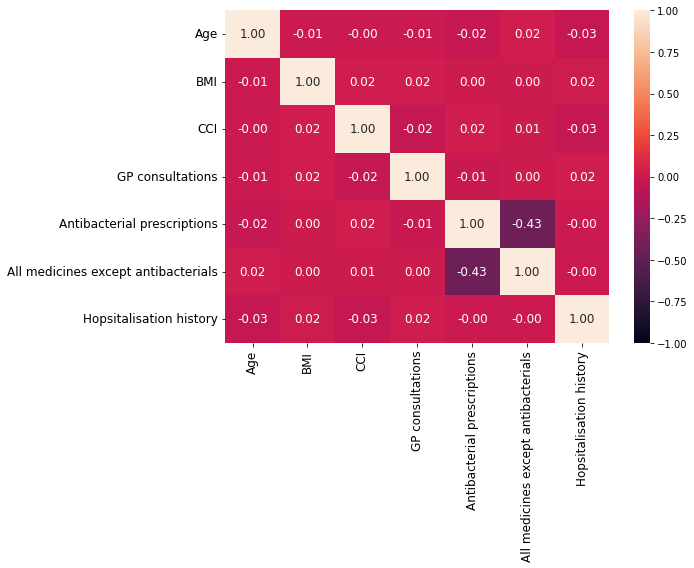

In [45]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_ot_externa[['age', 'bmi', 'CCI', 'gp_count', 'antibacterial_brit', 'hx_hosp']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'GP consultations', 'Antibacterial prescriptions', 'Hopsitalisation history'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'GP consultations', 'Antibacterial prescriptions', 'Hopsitalisation history'], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/corr_ot_externa.jpg')
plt.show()

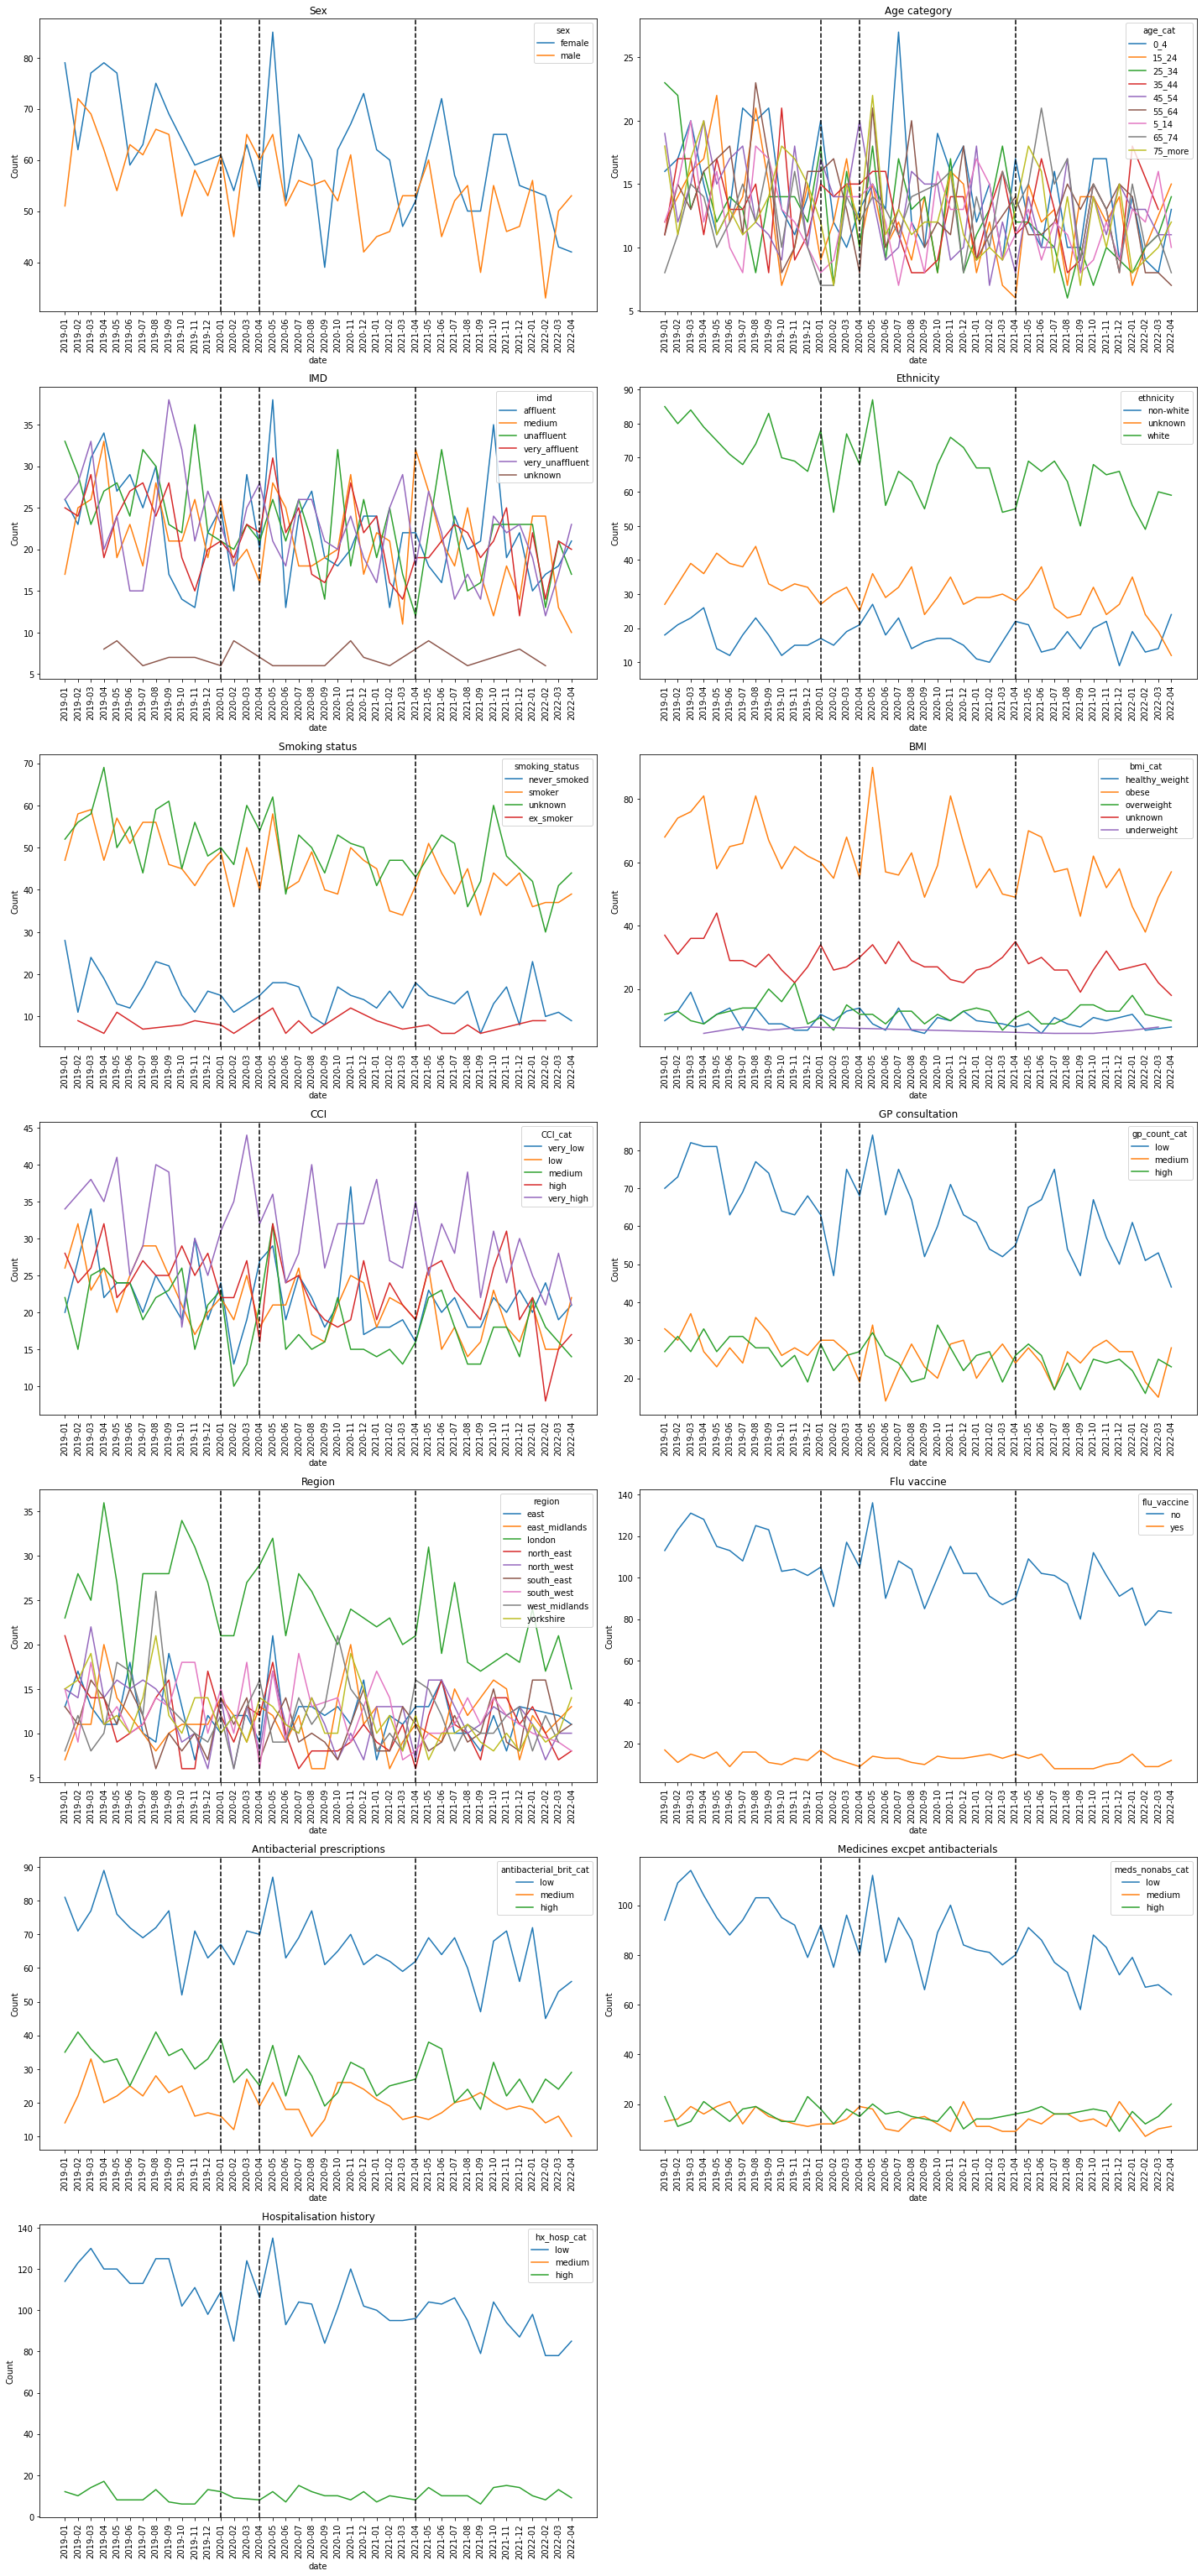

In [48]:
fig, axes = plt.subplots(6,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_ot_externa, 'sex', 'Sex', axes[0,0])
create_lineplot(data_ot_externa, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_ot_externa, 'imd', 'IMD', axes[1,0])
create_lineplot(data_ot_externa, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_ot_externa, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_ot_externa, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_ot_externa, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_ot_externa, 'gp_count_cat', 'GP consultation', axes[3,1])
create_lineplot(data_ot_externa, 'region', 'Region', axes[4,0])
create_lineplot(data_ot_externa, 'flu_vaccine', 'Flu vaccine', axes[4,1])
create_lineplot(data_ot_externa, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[5,0])
# create_lineplot(data_ot_externa, 'meds_nonabs_cat', 'Medicines excpet antibacterials', axes[5,1])
create_lineplot(data_ot_externa, 'hx_hosp_cat', 'Hospitalisation history', axes[5,1])
# fig.delaxes(ax=axes[6,1])

# fig.suptitle('Risk Factors of ot_externa patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/risk_factors_cat_ot_externa.jpg')
plt.show()

## 4- Separate data of incident/prevalent and with/without antibiotics
We separate data of ot_externa to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [133]:
data_ot_externa = data_ot_externa[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 
                        'smoking_status', 'season', #'antibacterial_brit_cat', 'gp_count_cat', 'meds_nonabs_cat', 'hx_hosp_cat',
                        'antibacterial_brit', 'gp_count', #'meds_nonabs', 'hx_hosp',
                        'event_ot_externa_admitted', 'duration_ot_externa_admitted',
                        'ot_externa_ab_date', 'incdt_ot_externa_date',
                        'date']]

data_ot_externa.shape

(4902, 18)

In [134]:
# no antibiotics and incident hospital admission
data_ot_externa_no_abs_incdt = data_ot_externa[data_ot_externa['ot_externa_ab_date'].isnull()] #gp_cons_ot_externa_ab
data_ot_externa_no_abs_incdt = data_ot_externa_no_abs_incdt[data_ot_externa_no_abs_incdt['incdt_ot_externa_date'] == 0]

# with antibiotics and incident hospital admission
data_ot_externa_abs_incdt = data_ot_externa[data_ot_externa['ot_externa_ab_date'].notnull()]
data_ot_externa_abs_incdt = data_ot_externa_abs_incdt[data_ot_externa_abs_incdt['incdt_ot_externa_date'] == 0]

# no antibiotics and prevalent hospital admission
data_ot_externa_no_abs_prevl = data_ot_externa[data_ot_externa['ot_externa_ab_date'].isnull()]
data_ot_externa_no_abs_prevl = data_ot_externa_no_abs_prevl[data_ot_externa_no_abs_prevl['incdt_ot_externa_date'] == 1]

# with antibiotics and prevalent hospital admission
data_ot_externa_abs_prevl = data_ot_externa[data_ot_externa['ot_externa_ab_date'].notnull()]
data_ot_externa_abs_prevl = data_ot_externa_abs_prevl[data_ot_externa_abs_prevl['incdt_ot_externa_date'] == 1]

print(f'shape of data_ot_externa_no_abs_incdt: {data_ot_externa_no_abs_incdt.shape}')
print(f'shape of data_ot_externa_abs_incdt: {data_ot_externa_abs_incdt.shape}')
print(f'shape of data_ot_externa_no_abs_prevl: {data_ot_externa_no_abs_prevl.shape}')
print(f'shape of data_ot_externa_abs_prevl: {data_ot_externa_abs_prevl.shape}')

shape of data_urti_no_abs_incdt: (3976, 18)
shape of data_urti_abs_incdt: (451, 18)
shape of data_urti_no_abs_prevl: (426, 18)
shape of data_urti_abs_prevl: (49, 18)


In [ ]:
#store data for plotting hosp admission counts and percentages
%store data_ot_externa
# save data
data_ot_externa.to_csv('../output/hospitalisation_prediction_ot_externa/data_ot_externa.csv')

In [135]:
print(f'shape of data_ot_externa_no_abs_incdt: \n{data_ot_externa_no_abs_incdt.event_ot_externa_admitted.value_counts()}')
print(f'shape of data_ot_externa_abs_incdt: \n{data_ot_externa_abs_incdt.event_ot_externa_admitted.value_counts()}')
print(f'shape of data_ot_externa_no_abs_prevl: \n{data_ot_externa_no_abs_prevl.event_ot_externa_admitted.value_counts()}')
print(f'shape of data_ot_externa_abs_prevl: \n{data_ot_externa_abs_prevl.event_ot_externa_admitted.value_counts()}')

shape of data_urti_no_abs_incdt: 
0.0    3947
1.0      29
Name: event_urti_admitted, dtype: int64
shape of data_urti_abs_incdt: 
0.0    448
1.0      3
Name: event_urti_admitted, dtype: int64
shape of data_urti_no_abs_prevl: 
0.0    419
1.0      7
Name: event_urti_admitted, dtype: int64
shape of data_urti_abs_prevl: 
0.0    47
1.0     2
Name: event_urti_admitted, dtype: int64


In [ ]:
# save data shape
a = open("../output/hospitalisation_prediction_ot_externa/data_shape_cph_ot_externa.txt", "w")
a.write("")
a.writelines(['data_ot_externa_no_abs_incdt #observations, #events: %.0f' % (data_ot_externa_no_abs_incdt.event_ot_externa_admitted.value_counts()[0]), ', %.0f' % (data_ot_externa_no_abs_incdt.event_ot_externa_admitted.value_counts()[1]),
              '\ndata_ot_externa_abs_incdt #observations, #events: %.0f' % (data_ot_externa_abs_incdt.event_ot_externa_admitted.value_counts()[0]), ', %.0f' % (data_ot_externa_abs_incdt.event_ot_externa_admitted.value_counts()[1]),
              '\ndata_ot_externa_no_abs_prevl #observations, #events: %.0f' % (data_ot_externa_no_abs_prevl.event_ot_externa_admitted.value_counts()[0]), ', %.0f' % (data_ot_externa_no_abs_prevl.event_ot_externa_admitted.value_counts()[1]),
              '\ndata_ot_externa_abs_prevl #observations, #events: %.0f' % (data_ot_externa_abs_prevl.event_ot_externa_admitted.value_counts()[0]), ', %.0f' % (data_ot_externa_abs_prevl.event_ot_externa_admitted.value_counts()[1])
              ])

## 5- Cox modelling for hospital admissions related to infections 
### 5-1- ot_externa
#### 5-1-1- Incident hospital admission related to ot_externa with no antibiotics

In [136]:
#keep relevant variables
data_ot_externa_no_abs_incdt = data_ot_externa_no_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 
                                                 'imd', 'ethnicity', 'smoking_status', 'season', 
                                                # 'antibacterial_brit_cat', 'gp_count_cat', 'meds_nonabs_cat', 'hx_hosp_cat',                                               
                                                 'antibacterial_brit', 'gp_count', #'meds_nonabs', 'hx_hosp',
                                                 'event_ot_externa_admitted', 'duration_ot_externa_admitted']]

data_ot_externa_no_abs_incdt.shape

(3976, 16)

In [137]:
# encoding categorical data for CPH
data = data_ot_externa_no_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_ot_externa_no_abs_incdt_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_ot_externa_no_abs_incdt_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_ot_externa_no_abs_incdt_enc = data[['antibacterial_brit', 'gp_count']].join(data_ot_externa_no_abs_incdt_enc) #, 'gp_count', 'meds_nonabs', 'hx_hosp', 'event_ot_externa_admitted', 'duration_ot_externa_admitted'

data_ot_externa_no_abs_incdt_enc.head()

,antibacterial_brit,gp_count,meds_nonabs,age_cat_0_4,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_55_64,age_cat_5_14,...,ethnicity_unknown,ethnicity_white,smoking_status_ex_smoker,smoking_status_never_smoked,smoking_status_smoker,smoking_status_unknown,season_autumn,season_spring,season_summer,season_winter
0,2.0,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.0,10.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,2.0,8.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
#summary table
summary_table_ot_externa_no_abs_incdt = data_ot_externa_no_abs_incdt_enc.sum(axis=0).reset_index()
summary_table_ot_externa_no_abs_incdt.columns = ['variable', 'count']
summary_table_ot_externa_no_abs_incdt['mean'] = data_ot_externa_no_abs_incdt_enc.mean(axis=0).reset_index()[0]
#round count to make last digit either 0 or 5
summary_table_ot_externa_no_abs_incdt['count'] = round_five_mul(summary_table_ot_externa_no_abs_incdt['count'], base=5)
summary_table_ot_externa_no_abs_incdt['std'] = data_ot_externa_no_abs_incdt_enc.std(axis=0).reset_index()[0]
#replace small counts (<=5) with 'SM'
summary_table_ot_externa_no_abs_incdt.loc[(summary_table_ot_externa_no_abs_incdt['count'] <= 5), 'count'] = 'SM'
# summary_table_ot_externa_no_abs_incdt

# save table
summary_table_ot_externa_no_abs_incdt.to_csv('../output/hospitalisation_prediction_ot_externa/summary_table_ot_externa_no_abs_incdt.csv', index=False)

In [138]:
#randomly splitting data into training (%75) and testing (%25)
data_ot_externa_no_abs_incdt_train, data_ot_externa_no_abs_incdt_test = train_test_split(data_ot_externa_no_abs_incdt, test_size=0.25, random_state=42)

print(f'shape of data_ot_externa_no_abs_incdt for training: {data_ot_externa_no_abs_incdt_train.shape}')
print(f'shape of data_ot_externa_no_abs_incdt for testing: {data_ot_externa_no_abs_incdt_test.shape}')

shape of data_urti_no_abs_incdt for training: (2982, 16)
shape of data_urti_no_abs_incdt for testing: (994, 16)


In [139]:
cph_ot_externa_no_abs_incdt = CoxPHFitter()
cph_ot_externa_no_abs_incdt.fit(data_ot_externa_no_abs_incdt_train,
        duration_col='duration_ot_externa_admitted',
        event_col='event_ot_externa_admitted',
        formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + gp_count"# + meds_nonabs + hx_hosp 
        )
cph_ot_externa_no_abs_incdt.print_summary()

<lifelines.CoxPHFitter: fitted with 2982 total observations, 2959 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 2982
number of events observed = 23
   partial log-likelihood = -161.23
         time fit was run = 2022-06-09 14:49:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.88       0.41       0.85            -2.54             0.78                 0.08                 2.19
CCI_cat[T.medium]               -0.85       0.43       0.85            -2.51             0.81                 0.08                 2.24
CCI_cat[T.high]                 -0.10       0.90       0.65            -1.38             1.18                 0.25                 3.25
CCI_cat[T.very_high]             0.22       1.25       0.57            -0.90             1.34                 0.41                 3.83
age_cat[T.15_24]                17.77   5.24e+07    4943.53         -9671.36          9706.91                 0.00                  inf
age_cat[T.25_34]                18.26   8.53e+07    4943.53         -9670.87          9707.40                 0.00                  inf
age_cat[T.35_44]                17.00   2.40e+07    4943.53         -9672.14          9706.13                 0.00                  inf
age_cat[T.45_54]                18.38   9.63e+07    4943.53         -9670.75          9707.52                 0.00                  inf
age_cat[T.55_64]                17.62   4.47e+07    4943.53         -9671.52          9706.75                 0.00                  inf
age_cat[T.5_14]                 17.52   4.08e+07    4943.53         -9671.61          9706.66                 0.00                  inf
age_cat[T.65_74]                18.85   1.54e+08    4943.53         -9670.28          9707.99                 0.00                  inf
age_cat[T.75_more]              18.09   7.20e+07    4943.53         -9671.04          9707.23                 0.00                  inf
antibacterial_brit               0.04       1.05       0.15            -0.25             0.34                 0.78                 1.41
bmi_cat[T.obese]                -0.57       0.57       0.67            -1.88             0.75                 0.15                 2.11
bmi_cat[T.overweight]           -0.47       0.62       0.85            -2.14             1.19                 0.12                 3.28
bmi_cat[T.underweight]          -0.32       0.73       1.18            -2.62             1.99                 0.07                 7.29
bmi_cat[T.unknown]              -0.40       0.67       0.75            -1.87             1.08                 0.15                 2.93
ethnicity[T.unknown]             0.08       1.08       0.61            -1.11             1.27                 0.33                 3.55
ethnicity[T.white]              -0.55       0.58       0.55            -1.63             0.54                 0.20                 1.72
flu_vaccine[T.yes]               0.21       1.23       0.64            -1.04             1.46                 0.35                 4.32
gp_count                        -0.06       0.94       0.07            -0.19             0.07                 0.83                 1.07
imd[T.medium]                    0.54       1.72       0.65            -0.74             1.82                 0.48                 6.19
imd[T.unaffluent]               -0.76       0.47       0.88            -2.48             0.96                 0.08                 2.61
imd[T.unknown]                   0.93       2.54       0.89            -0.81             2.68                 0.44                14.53
imd[T.very_affluent]             0.36       1.43       0.68            -0

In [140]:
output = GetPrintSummary(cph_ot_externa_no_abs_incdt)

with open('../output/hospitalisation_prediction_ot_externa/cph_ot_externa_no_abs_incdt_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

13973


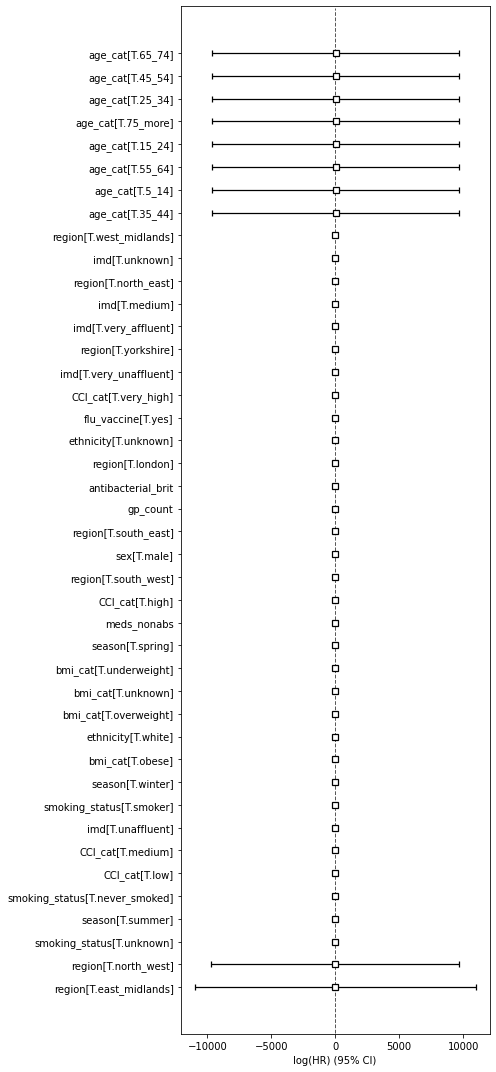

In [141]:
# # save betas of cph model
# # a = cph_ot_externa_no_abs_incdt.baseline_hazard_
# a = cph_ot_externa_no_abs_incdt.hazard_ratios_#.reset_index()
# a.to_csv('../output/hospitalisation_prediction_ot_externa/betas_cph_ot_externa_no_abs_incdt.csv')
# np.savetxt('../output/hospitalisation_prediction_ot_externa/betas_cph_ot_externa_no_abs_incdt.txt', a, delimiter=',')

# plot betas
fig, ax = plt.subplots(figsize=(7, 15))
cph_ot_externa_no_abs_incdt.plot()
# plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to ot_externa with no antibiotics', fontsize=16)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/coef_cph_ot_externa_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [142]:
# cleaning up covariates to make them compatible with the encoded data
covariates = cph_ot_externa_no_abs_incdt.params_.reset_index()#.covariate
covariates.covariate = covariates.covariate.str.replace("[","")
covariates.covariate = covariates.covariate.str.replace("]","")
covariates.covariate = covariates.covariate.str.replace("T.","_")
# covariates.shape

# save coefficients
covariates.to_csv('../output/hospitalisation_prediction_ot_externa/betas_cph_ot_externa_no_abs_incdt.csv', index=False)

# transpose and sort covariates and coefficients
covariatesT = covariates.T
# covariatesT.covariate = covariates
header = covariatesT.iloc[0]
covariatesT = covariatesT[1:]
covariatesT.columns = header
covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
# covariatesT.shape

# further cleaning up covariates to make them compatible with the encoded data
mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

#match mylist (covariates of cox model) with encoded data
data = data_ot_externa_no_abs_incdt_enc[data_ot_externa_no_abs_incdt_enc.columns.intersection(mylist)] 
data = data.sort_index(axis = 1) #sort 
# data.shape

# multiply betas and encoded data
betas = data.multiply(np.array(covariatesT), axis='columns')
# betas

# sum up betas of each row to calculate sum of betas 
sum_betas = betas.sum(axis=1)
# sum_betas

In [143]:
# predict cumulative hazard values at day 30 and match them with sum of betas
sum_betas_hazard = cph_ot_externa_no_abs_incdt.predict_cumulative_hazard(data_ot_externa_no_abs_incdt).loc[[30]].T.reset_index(drop=True)
sum_betas_hazard['sum_betas'] = sum_betas
# sum_betas_hazard

# sort values of sum of betas
sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
# sum_betas_hazard

# binning sum of betas into 100 bins
sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
# sum_betas_hazard

#calculate mean of cumulative hazar at day 30 by groupby 
sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
# sum_betas_hazard_groupby

#calculate interpolation of missing mean values 
sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

# separate upper and lower boundries of bins
sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
# sum_betas_hazard_groupby.head()

# select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean', 'mean_interpolate']]

# save relevant columns of sum_betas
sum_betas.to_csv('../output/hospitalisation_prediction_ot_externa/sum_betas_cph_ot_externa_no_abs_incdt.csv', index=False)
np.savetxt('../output/hospitalisation_prediction_ot_externa/sum_betas_cph_ot_externa_no_abs_incdt.txt', sum_betas, delimiter=',')

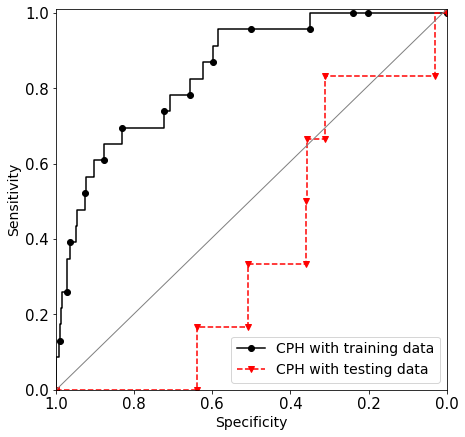

In [144]:
# analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
cph_ot_externa_no_abs_incdt_train_cumulative_hazard = cph_ot_externa_no_abs_incdt.predict_cumulative_hazard(data_ot_externa_no_abs_incdt_train)
cph_ot_externa_no_abs_incdt_train_cumulative_hazard = cph_ot_externa_no_abs_incdt_train_cumulative_hazard.loc[[30]].T
cph_ot_externa_no_abs_incdt_train_cumulative_hazard['event_ot_externa_admitted'] = data_ot_externa_no_abs_incdt_train['event_ot_externa_admitted']
cph_ot_externa_no_abs_incdt_train_cumulative_hazard = cph_ot_externa_no_abs_incdt_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# cph_ot_externa_no_abs_incdt_train_cumulative_hazard

# analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
cph_ot_externa_no_abs_incdt_test_cumulative_hazard = cph_ot_externa_no_abs_incdt.predict_cumulative_hazard(data_ot_externa_no_abs_incdt_test)
cph_ot_externa_no_abs_incdt_test_cumulative_hazard = cph_ot_externa_no_abs_incdt_test_cumulative_hazard.loc[[30]].T
cph_ot_externa_no_abs_incdt_test_cumulative_hazard['event_ot_externa_admitted'] = data_ot_externa_no_abs_incdt_test['event_ot_externa_admitted']
cph_ot_externa_no_abs_incdt_test_cumulative_hazard = cph_ot_externa_no_abs_incdt_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# cph_ot_externa_no_abs_incdt_test_cumulative_hazard

# plot roc curves
r_fpr1, r_tpr1, _ = roc_curve(cph_ot_externa_no_abs_incdt_train_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_no_abs_incdt_train_cumulative_hazard.cumulative_hazard)
r_fpr2, r_tpr2, _ = roc_curve(cph_ot_externa_no_abs_incdt_test_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_no_abs_incdt_test_cumulative_hazard.cumulative_hazard)

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

squares = [0,1.01]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of CPH for hospital admission related to incident \not_externa with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/roc_cph_ot_externa_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [ ]:
#predict cumulative hazard in day 30
prob_pred_true_train = cph_ot_externa_no_abs_incdt.predict_cumulative_hazard(data_ot_externa_no_abs_incdt_train).loc[[30]].T
prob_pred_true_train.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_ot_externa_no_abs_incdt_train.event_ot_externa_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_ot_externa_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin


#predict cumulative hazard in day 30
prob_pred_true_test = cph_ot_externa_no_abs_incdt.predict_cumulative_hazard(data_ot_externa_no_abs_incdt_test).loc[[30]].T
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_ot_externa_no_abs_incdt_test.event_ot_externa_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_ot_externa_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_ot_externa/calibration_cph_ot_externa_no_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_ot_externa/calibration_cph_ot_externa_no_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [147]:
# calculate concordance index, AUROC, and Brier score of cph model
concord_index_ot_externa_no_abs_incdt_train = concordance_index(data_ot_externa_no_abs_incdt_train['duration_ot_externa_admitted'], -cph_ot_externa_no_abs_incdt.predict_partial_hazard(data_ot_externa_no_abs_incdt_train), data_ot_externa_no_abs_incdt_train['event_ot_externa_admitted'])
concord_index_ot_externa_no_abs_incdt_test = concordance_index(data_ot_externa_no_abs_incdt_test['duration_ot_externa_admitted'], -cph_ot_externa_no_abs_incdt.predict_partial_hazard(data_ot_externa_no_abs_incdt_test), data_ot_externa_no_abs_incdt_test['event_ot_externa_admitted'])
r_auc1 = roc_auc_score(cph_ot_externa_no_abs_incdt_train_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_no_abs_incdt_train_cumulative_hazard.cumulative_hazard)
r_auc2 = roc_auc_score(cph_ot_externa_no_abs_incdt_test_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_no_abs_incdt_test_cumulative_hazard.cumulative_hazard)
brier1 = brier_score_loss(cph_ot_externa_no_abs_incdt_train_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_no_abs_incdt_train_cumulative_hazard.cumulative_hazard)
brier2 = brier_score_loss(cph_ot_externa_no_abs_incdt_test_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_no_abs_incdt_test_cumulative_hazard.cumulative_hazard)

# save model outputs
a = open("../output/hospitalisation_prediction_ot_externa/cph_ot_externa_no_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['Concordance index for ot_externa_no_abs_incdt with testing data: %.4f' % (concord_index_ot_externa_no_abs_incdt_test), 
              '\nConcordance index for ot_externa_no_abs_incdt with training data: %.4f' % (concord_index_ot_externa_no_abs_incdt_train),
              '\nAUROC of CPH with training data of hospital admission related to incident ot_externa with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of CPH with testing data of hospital admission related to incident ot_externa with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of CPH with training data of hospital admission related to incident ot_externa with no antibiotics = %.4f' % (brier1),
              '\nBrier score of CPH with testing data of hospital admission related to incident ot_externa with no antibiotics = %.4f' % (brier2)])

#### 5-1-2- Incident hospital admission related to ot_externa with antibiotics

In [80]:
#keep relevant variables
data_ot_externa_abs_incdt = data_ot_externa_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 
                                           'imd', 'ethnicity', 'smoking_status', 'season', 
                                        #    'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat', 
                                           'antibacterial_brit', 'gp_count',  #'meds_nonabs', 'hx_hosp', 
                                           'event_ot_externa_admitted', 'duration_ot_externa_admitted']]

In [81]:
# encoding categorical data for CPH
data = data_ot_externa_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_ot_externa_abs_incdt_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_ot_externa_abs_incdt_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_ot_externa_abs_incdt_enc = data[['antibacterial_brit', 'gp_count']].join(data_ot_externa_abs_incdt_enc) # , 'meds_nonabs', 'hx_hosp', 'event_ot_externa_admitted', 'duration_ot_externa_admitted'

data_ot_externa_abs_incdt_enc.head()

,antibacterial_brit,gp_count,meds_nonabs,age_cat_0_4,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_55_64,age_cat_5_14,...,ethnicity_Unknown,ethnicity_White,smoking_status_Ex_smoker,smoking_status_Never_smoked,smoking_status_Smoker,smoking_status_Unknown,season_Autumn,season_Spring,season_Summer,season_Winter
0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [ ]:
#summary table
summary_table_ot_externa_abs_incdt = data_ot_externa_abs_incdt_enc.sum(axis=0).reset_index()
summary_table_ot_externa_abs_incdt.columns = ['variable', 'count']
#round count to make last digit either 0 or 5
summary_table_ot_externa_abs_incdt['mean'] = data_ot_externa_abs_incdt_enc.mean(axis=0).reset_index()[0]
summary_table_ot_externa_abs_incdt['count'] = round_five_mul(summary_table_ot_externa_abs_incdt['count'], base=5)
summary_table_ot_externa_abs_incdt['std'] = data_ot_externa_abs_incdt_enc.std(axis=0).reset_index()[0]
#replace small counts (<=5) with 'SM'
summary_table_ot_externa_abs_incdt.loc[(summary_table_ot_externa_abs_incdt['count'] <= 5), 'count'] = 'SM'
# summary_table_ot_externa_abs_incdt

# save table
summary_table_ot_externa_abs_incdt.to_csv('../output/hospitalisation_prediction_ot_externa/summary_table_ot_externa_abs_incdt.csv', index=False)

In [82]:
#randomly splitting data into training (%75) and testing (%25)
data_ot_externa_abs_incdt_train, data_ot_externa_abs_incdt_test = train_test_split(data_ot_externa_abs_incdt, test_size=0.25, random_state=42)

print(f'shape of data_ot_externa_abs_incdt for training: {data_ot_externa_abs_incdt_train.shape}')
print(f'shape of data_ot_externa_abs_incdt for testing: {data_ot_externa_abs_incdt_test.shape}')

shape of data_urti_abs_incdt for training: (338, 16)
shape of data_urti_abs_incdt for testing: (113, 16)


In [83]:
cph_ot_externa_abs_incdt = CoxPHFitter().fit(data_ot_externa_abs_incdt_train,
        duration_col='duration_ot_externa_admitted',
        event_col='event_ot_externa_admitted',
        formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + gp_count "# + meds_nonabs + hx_hosp
        )
cph_ot_externa_abs_incdt.print_summary()

<lifelines.CoxPHFitter: fitted with 338 total observations, 336 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 338
number of events observed = 2
   partial log-likelihood = -0.69
         time fit was run = 2022-06-09 13:11:50 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.Low]                  -5.38       0.00   19282.37        -37798.12         37787.37                 0.00                  inf
CCI_cat[T.Medium]               -1.74       0.18   18709.98        -36672.63         36669.16                 0.00                  inf
CCI_cat[T.High]                  0.17       1.19   18478.89        -36217.78         36218.13                 0.00                  inf
CCI_cat[T.Very_high]             2.41      11.09   14577.70        -28569.37         28574.18                 0.00                  inf
age_cat[T.15_24]                 3.69      40.01   28527.27        -55908.73         55916.11                 0.00                  inf
age_cat[T.25_34]                11.02   61372.71   19309.30        -37834.52         37856.56                 0.00                  inf
age_cat[T.35_44]                -1.51       0.22   24099.14        -47234.96         47231.93                 0.00                  inf
age_cat[T.45_54]                 5.30     199.68   20597.86        -40365.76         40376.36                 0.00                  inf
age_cat[T.55_64]                 2.52      12.49   27406.78        -53713.78         53718.83                 0.00                  inf
age_cat[T.5_14]                 -2.13       0.12   21887.74        -42901.32         42897.06                 0.00                  inf
age_cat[T.65_74]                14.30   1.62e+06   15113.82        -29608.24         29636.83                 0.00                  inf
age_cat[T.75_or_more]            4.76     117.03   21742.99        -42610.71         42620.24                 0.00                  inf
antibacterial_brit               1.08       2.94    3273.67         -6415.20          6417.36                 0.00                  inf
bmi_cat[T.Obese]                 0.31       1.36   26510.54        -51959.40         51960.01                 0.00                  inf
bmi_cat[T.Overweight]           -2.00       0.14   29574.93        -57967.80         57963.81                 0.00                  inf
bmi_cat[T.Underweight]          -6.20       0.00   36932.22        -72392.03         72379.63                 0.00                  inf
bmi_cat[T.Unknown]              -3.88       0.02   27646.73        -54190.48         54182.72                 0.00                  inf
ethnicity[T.Unknown]             3.64      37.98   16495.99        -32327.91         32335.18                 0.00                  inf
ethnicity[T.White]               8.03    3083.67   15930.65        -31215.47         31231.53                 0.00                  inf
flu_vaccine[T.Yes]              -0.21       0.81   22301.57        -43710.49         43710.07                 0.00                  inf
gp_count                        -0.50       0.61    2077.94         -4073.19          4072.19                 0.00                  inf
imd[T.Medium]                   -1.66       0.19   17751.58        -34794.10         34790.79                 0.00                  inf
imd[T.Unaffluent]                7.92    2747.98   12128.99        -23764.47         23780.31                 0.00                  inf
imd[T.Unknown]                   6.05     424.48   41315.47        -80970.78         80982.88                 0.00                  inf
imd[T.Very_affluent]            -0.04       0.96   19430.53        -38083.17   

In [84]:
output = GetPrintSummary(cph_ot_externa_abs_incdt)

with open('../output/hospitalisation_prediction_ot_externa/cph_ot_externa_abs_incdt_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

14336


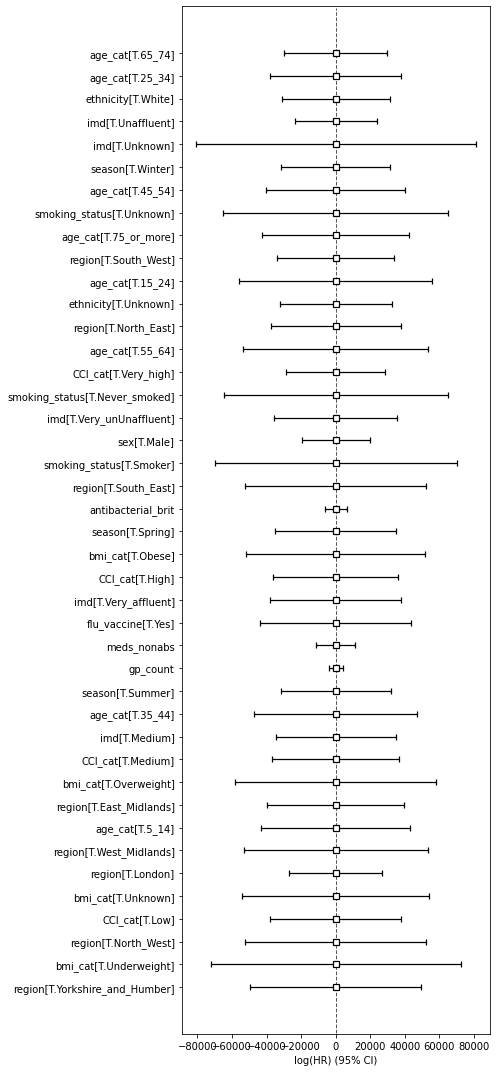

In [85]:
# # save betas of cph model
# a = cph_ot_externa_abs_incdt.baseline_hazard_
# np.savetxt('../output/hospitalisation_prediction_ot_externa/betas_cph_ot_externa_abs_incdt.txt', a, delimiter=',')

# plot betas
fig, ax = plt.subplots(figsize=(7, 15))
cph_ot_externa_abs_incdt.plot()
# plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to ot_externa with antibiotics', fontsize=16)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/coef_cph_ot_externa_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [86]:
# cleaning up covariates to make them compatible with the encoded data
covariates = cph_ot_externa_abs_incdt.params_.reset_index()#.covariate
covariates.covariate = covariates.covariate.str.replace("[","")
covariates.covariate = covariates.covariate.str.replace("]","")
covariates.covariate = covariates.covariate.str.replace("T.","_")
# covariates.shape

# save coefficients
covariates.to_csv('../output/hospitalisation_prediction_ot_externa/betas_cph_ot_externa_abs_incdt.csv', index=False)

# transpose and sort covariates and coefficients
covariatesT = covariates.T
# covariatesT.covariate = covariates
header = covariatesT.iloc[0]
covariatesT = covariatesT[1:]
covariatesT.columns = header
covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
# covariatesT.shape

# further cleaning up covariates to make them compatible with the encoded data
mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark

# match mylist (covariates of cox model) with encoded data
data = data_ot_externa_abs_incdt_enc[data_ot_externa_abs_incdt_enc.columns.intersection(mylist)] 
data = data.sort_index(axis = 1) #sort 
# data.shape

# multiply betas and encoded data
betas = data.multiply(np.array(covariatesT), axis='columns')
# betas

# sum up betas of each row to calculate sum of betas 
sum_betas = betas.sum(axis=1)
# sum_betas

In [181]:
# predict cumulative hazard values at day 30 and match them with sum of betas
sum_betas_hazard = cph_ot_externa_abs_incdt.predict_cumulative_hazard(data_ot_externa_abs_incdt).loc[[30]].T.reset_index(drop=True)
sum_betas_hazard['sum_betas'] = sum_betas
# sum_betas_hazard

# sort values of sum of betas
sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
# sum_betas_hazard

# binning sum of betas into 100 bins
sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
# sum_betas_hazard

# calculate mean of cumulative hazar at day 30 by groupby 
sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
# sum_betas_hazard_groupby.head()

# calculate interpolation of missing mean values 
sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

# separate upper and lower boundries of bin
sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
# sum_betas_hazard_groupby.head()

# select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard 
sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean', 'mean_interpolate']]

# save relevant columns of sum_betas
sum_betas.to_csv('../output/hospitalisation_prediction_ot_externa/sum_betas_cph_ot_externa_abs_incdt.csv', index=False)
np.savetxt('../output/hospitalisation_prediction_ot_externa/sum_betas_cph_ot_externa_abs_incdt.txt', sum_betas, delimiter=',')

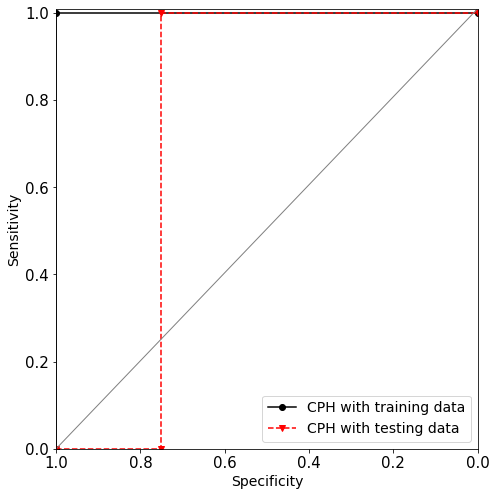

In [182]:
# analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event
cph_ot_externa_abs_incdt_train_cumulative_hazard = cph_ot_externa_abs_incdt.predict_cumulative_hazard(data_ot_externa_abs_incdt_train)
cph_ot_externa_abs_incdt_train_cumulative_hazard = cph_ot_externa_abs_incdt_train_cumulative_hazard.loc[[30]].T
cph_ot_externa_abs_incdt_train_cumulative_hazard['event_ot_externa_admitted'] = data_ot_externa_abs_incdt_train['event_ot_externa_admitted']
cph_ot_externa_abs_incdt_train_cumulative_hazard = cph_ot_externa_abs_incdt_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# cph_ot_externa_abs_incdt_train_cumulative_hazard

# analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event
cph_ot_externa_abs_incdt_test_cumulative_hazard = cph_ot_externa_abs_incdt.predict_cumulative_hazard(data_ot_externa_abs_incdt_test)
cph_ot_externa_abs_incdt_test_cumulative_hazard = cph_ot_externa_abs_incdt_test_cumulative_hazard.loc[[30]].T
cph_ot_externa_abs_incdt_test_cumulative_hazard['event_ot_externa_admitted'] = data_ot_externa_abs_incdt_test['event_ot_externa_admitted']
cph_ot_externa_abs_incdt_test_cumulative_hazard = cph_ot_externa_abs_incdt_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# cph_ot_externa_abs_incdt_test_cumulative_hazard

# plot roc curves
r_fpr1, r_tpr1, _ = roc_curve(cph_ot_externa_abs_incdt_train_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_abs_incdt_train_cumulative_hazard.cumulative_hazard)
r_fpr2, r_tpr2, _ = roc_curve(cph_ot_externa_abs_incdt_test_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_abs_incdt_test_cumulative_hazard.cumulative_hazard)

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

squares = [0,1.01]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of CPH for hospital admission related to incident \not_externa with antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/roc_cph_ot_externa_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [ ]:
#predict cumulative hazard in day 30
prob_pred_true_train = cph_ot_externa_abs_incdt.predict_cumulative_hazard(data_ot_externa_abs_incdt_train).loc[[30]].T
prob_pred_true_train.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_ot_externa_abs_incdt_train.event_ot_externa_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_ot_externa_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin


#predict cumulative hazard in day 30
prob_pred_true_test = cph_ot_externa_abs_incdt.predict_cumulative_hazard(data_ot_externa_abs_incdt_test).loc[[30]].T
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_ot_externa_abs_incdt_test.event_ot_externa_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_ot_externa_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_ot_externa/calibration_cph_ot_externa_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_ot_externa/calibration_cph_ot_externa_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [185]:
# calculate concordance index, AUROC, and Brier score of cph model 
concord_index_ot_externa_abs_incdt_train = concordance_index(data_ot_externa_abs_incdt_train['duration_ot_externa_admitted'], -cph_ot_externa_abs_incdt.predict_partial_hazard(data_ot_externa_abs_incdt_train), data_ot_externa_abs_incdt_train['event_ot_externa_admitted'])
concord_index_ot_externa_abs_incdt_test = concordance_index(data_ot_externa_abs_incdt_test['duration_ot_externa_admitted'], -cph_ot_externa_abs_incdt.predict_partial_hazard(data_ot_externa_abs_incdt_test), data_ot_externa_abs_incdt_test['event_ot_externa_admitted'])
r_auc1 = roc_auc_score(cph_ot_externa_abs_incdt_train_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_abs_incdt_train_cumulative_hazard.cumulative_hazard)
r_auc2 = roc_auc_score(cph_ot_externa_abs_incdt_test_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_abs_incdt_test_cumulative_hazard.cumulative_hazard)
brier1 = brier_score_loss(cph_ot_externa_abs_incdt_train_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_abs_incdt_train_cumulative_hazard.cumulative_hazard)
brier2 = brier_score_loss(cph_ot_externa_abs_incdt_test_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_abs_incdt_test_cumulative_hazard.cumulative_hazard)

# save model outputs
a = open("../output/hospitalisation_prediction_ot_externa/cph_ot_externa_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['Concordance index for ot_externa_abs_incdt with testing data: %.4f' % (concord_index_ot_externa_abs_incdt_test), 
              '\nConcordance index for ot_externa_abs_incdt with training data: %.4f' % (concord_index_ot_externa_abs_incdt_train),
              '\nAUROC of CPH with training data of hospital admission related to incident ot_externa with antibiotics = %.4f' % (r_auc1),
              '\nAUROC of CPH with testing data of hospital admission related to incident ot_externa with antibiotics = %.4f' % (r_auc2),
              '\nBrier score of CPH with training data of hospital admission related to incident ot_externa with antibiotics = %.4f' % (brier1),
              '\nBrier score of CPH with testing data of hospital admission related to incident ot_externa with antibiotics = %.4f' % (brier2)])

#### 5-1-3- Prevalent hospital admission related to ot_externa with no antibiotics

In [186]:
#keep relevant variables
data_ot_externa_no_abs_prevl = data_ot_externa_no_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 
                                                 'imd', 'ethnicity', 'smoking_status', 'season', 
                                                # 'antibacterial_brit_cat', 'gp_count_cat', 'meds_nonabs_cat', 'hx_hosp_cat',                                               
                                                 'antibacterial_brit', 'gp_count', #'meds_nonabs', 'hx_hosp',
                                                 'event_ot_externa_admitted', 'duration_ot_externa_admitted']]

data_ot_externa_no_abs_prevl.shape

In [187]:
# encoding categorical data for CPH
data = data_ot_externa_no_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_ot_externa_no_abs_prevl_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_ot_externa_no_abs_prevl_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_ot_externa_no_abs_prevl_enc = data[['antibacterial_brit', 'gp_count']].join(data_ot_externa_no_abs_prevl_enc) #, 'gp_count', 'meds_nonabs', 'hx_hosp', 'event_ot_externa_admitted', 'duration_ot_externa_admitted'

data_ot_externa_no_abs_prevl_enc.head()

In [ ]:
#summary table
summary_table_ot_externa_no_abs_prevl = data_ot_externa_no_abs_prevl_enc.sum(axis=0).reset_index()
summary_table_ot_externa_no_abs_prevl.columns = ['variable', 'count']
summary_table_ot_externa_no_abs_prevl['mean'] = data_ot_externa_no_abs_prevl_enc.mean(axis=0).reset_index()[0]
#round count to make last digit either 0 or 5
summary_table_ot_externa_no_abs_prevl['count'] = round_five_mul(summary_table_ot_externa_no_abs_prevl['count'], base=5)
summary_table_ot_externa_no_abs_prevl['std'] = data_ot_externa_no_abs_prevl_enc.std(axis=0).reset_index()[0]
#replace small counts (<=5) with 'SM'
summary_table_ot_externa_no_abs_prevl.loc[(summary_table_ot_externa_no_abs_prevl['count'] <= 5), 'count'] = 'SM'
# summary_table_ot_externa_no_abs_prevl

# save table
summary_table_ot_externa_no_abs_prevl.to_csv('../output/hospitalisation_prediction_ot_externa/summary_table_ot_externa_no_abs_prevl.csv', index=False)

In [188]:
#randomly splitting data into training (%75) and testing (%25)
data_ot_externa_no_abs_prevl_train, data_ot_externa_no_abs_prevl_test = train_test_split(data_ot_externa_no_abs_prevl, test_size=0.25, random_state=42)

print(f'shape of data_ot_externa_no_abs_prevl for training: {data_ot_externa_no_abs_prevl_train.shape}')
print(f'shape of data_ot_externa_no_abs_prevl for testing: {data_ot_externa_no_abs_prevl_test.shape}')

In [189]:
cph_ot_externa_no_abs_prevl = CoxPHFitter()
cph_ot_externa_no_abs_prevl.fit(data_ot_externa_no_abs_prevl_train,
        duration_col='duration_ot_externa_admitted',
        event_col='event_ot_externa_admitted',
        formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + gp_count"# + meds_nonabs + hx_hosp 
        )
cph_ot_externa_no_abs_prevl.print_summary()

#save model output
output = GetPrintSummary(cph_ot_externa_no_abs_prevl)
with open('../output/hospitalisation_prediction_ot_externa/cph_ot_externa_no_abs_prevl_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

In [191]:
# plot betas
fig, ax = plt.subplots(figsize=(7, 15))
cph_ot_externa_no_abs_prevl.plot()
# plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to ot_externa with no antibiotics', fontsize=16)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/coef_cph_ot_externa_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [192]:
# cleaning up covariates to make them compatible with the encoded data
covariates = cph_ot_externa_no_abs_prevl.params_.reset_index()#.covariate
covariates.covariate = covariates.covariate.str.replace("[","")
covariates.covariate = covariates.covariate.str.replace("]","")
covariates.covariate = covariates.covariate.str.replace("T.","_")
# covariates.shape

# save coefficients
covariates.to_csv('../output/hospitalisation_prediction_ot_externa/betas_cph_ot_externa_no_abs_prevl.csv', index=False)

# transpose and sort covariates and coefficients
covariatesT = covariates.T
# covariatesT.covariate = covariates
header = covariatesT.iloc[0]
covariatesT = covariatesT[1:]
covariatesT.columns = header
covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
# covariatesT.shape

# further cleaning up covariates to make them compatible with the encoded data
mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

#match mylist (covariates of cox model) with encoded data
data = data_ot_externa_no_abs_prevl_enc[data_ot_externa_no_abs_prevl_enc.columns.intersection(mylist)] 
data = data.sort_index(axis = 1) #sort 
# data.shape

# multiply betas and encoded data
betas = data.multiply(np.array(covariatesT), axis='columns')
# betas

# sum up betas of each row to calculate sum of betas 
sum_betas = betas.sum(axis=1)
# sum_betas

In [193]:
# predict cumulative hazard values at day 30 and match them with sum of betas
sum_betas_hazard = cph_ot_externa_no_abs_prevl.predict_cumulative_hazard(data_ot_externa_no_abs_prevl).loc[[30]].T.reset_index(drop=True)
sum_betas_hazard['sum_betas'] = sum_betas
# sum_betas_hazard

# sort values of sum of betas
sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
# sum_betas_hazard

# binning sum of betas into 100 bins
sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
# sum_betas_hazard

#calculate mean of cumulative hazar at day 30 by groupby 
sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
# sum_betas_hazard_groupby

#calculate interpolation of missing mean values 
sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

# separate upper and lower boundries of bins
sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
# sum_betas_hazard_groupby.head()

# select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean', 'mean_interpolate']]

# save relevant columns of sum_betas
sum_betas.to_csv('../output/hospitalisation_prediction_ot_externa/sum_betas_cph_ot_externa_no_abs_prevl.csv', index=False)
np.savetxt('../output/hospitalisation_prediction_ot_externa/sum_betas_cph_ot_externa_no_abs_prevl.txt', sum_betas, delimiter=',')

In [194]:
# analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
cph_ot_externa_no_abs_prevl_train_cumulative_hazard = cph_ot_externa_no_abs_prevl.predict_cumulative_hazard(data_ot_externa_no_abs_prevl_train)
cph_ot_externa_no_abs_prevl_train_cumulative_hazard = cph_ot_externa_no_abs_prevl_train_cumulative_hazard.loc[[30]].T
cph_ot_externa_no_abs_prevl_train_cumulative_hazard['event_ot_externa_admitted'] = data_ot_externa_no_abs_prevl_train['event_ot_externa_admitted']
cph_ot_externa_no_abs_prevl_train_cumulative_hazard = cph_ot_externa_no_abs_prevl_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# cph_ot_externa_no_abs_prevl_train_cumulative_hazard

# analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
cph_ot_externa_no_abs_prevl_test_cumulative_hazard = cph_ot_externa_no_abs_prevl.predict_cumulative_hazard(data_ot_externa_no_abs_prevl_test)
cph_ot_externa_no_abs_prevl_test_cumulative_hazard = cph_ot_externa_no_abs_prevl_test_cumulative_hazard.loc[[30]].T
cph_ot_externa_no_abs_prevl_test_cumulative_hazard['event_ot_externa_admitted'] = data_ot_externa_no_abs_prevl_test['event_ot_externa_admitted']
cph_ot_externa_no_abs_prevl_test_cumulative_hazard = cph_ot_externa_no_abs_prevl_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# cph_ot_externa_no_abs_prevl_test_cumulative_hazard

# plot roc curves
r_fpr1, r_tpr1, _ = roc_curve(cph_ot_externa_no_abs_prevl_train_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_no_abs_prevl_train_cumulative_hazard.cumulative_hazard)
r_fpr2, r_tpr2, _ = roc_curve(cph_ot_externa_no_abs_prevl_test_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_no_abs_prevl_test_cumulative_hazard.cumulative_hazard)

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

squares = [0,1.01]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of CPH for hospital admission related to incident \not_externa with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/roc_cph_ot_externa_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [195]:
#predict cumulative hazard in day 30
prob_pred_true_train = cph_ot_externa_no_abs_prevl.predict_cumulative_hazard(data_ot_externa_no_abs_prevl_train).loc[[30]].T
prob_pred_true_train.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_ot_externa_no_abs_prevl_train.event_ot_externa_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_ot_externa_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin


#predict cumulative hazard in day 30
prob_pred_true_test = cph_ot_externa_no_abs_prevl.predict_cumulative_hazard(data_ot_externa_no_abs_prevl_test).loc[[30]].T
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_ot_externa_no_abs_prevl_test.event_ot_externa_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_ot_externa_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_ot_externa/calibration_cph_ot_externa_no_abs_prevl_train.jpg', bbox_inches='tight')
plt.show()

In [196]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_ot_externa/calibration_cph_ot_externa_no_abs_prevl_test.jpg', bbox_inches='tight')
plt.show()

In [197]:
# calculate concordance index, AUROC, and Brier score of cph model
concord_index_ot_externa_no_abs_prevl_train = concordance_index(data_ot_externa_no_abs_prevl_train['duration_ot_externa_admitted'], -cph_ot_externa_no_abs_prevl.predict_partial_hazard(data_ot_externa_no_abs_prevl_train), data_ot_externa_no_abs_prevl_train['event_ot_externa_admitted'])
concord_index_ot_externa_no_abs_prevl_test = concordance_index(data_ot_externa_no_abs_prevl_test['duration_ot_externa_admitted'], -cph_ot_externa_no_abs_prevl.predict_partial_hazard(data_ot_externa_no_abs_prevl_test), data_ot_externa_no_abs_prevl_test['event_ot_externa_admitted'])
r_auc1 = roc_auc_score(cph_ot_externa_no_abs_prevl_train_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_no_abs_prevl_train_cumulative_hazard.cumulative_hazard)
r_auc2 = roc_auc_score(cph_ot_externa_no_abs_prevl_test_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_no_abs_prevl_test_cumulative_hazard.cumulative_hazard)
brier1 = brier_score_loss(cph_ot_externa_no_abs_prevl_train_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_no_abs_prevl_train_cumulative_hazard.cumulative_hazard)
brier2 = brier_score_loss(cph_ot_externa_no_abs_prevl_test_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_no_abs_prevl_test_cumulative_hazard.cumulative_hazard)

# save model outputs
a = open("../output/hospitalisation_prediction_ot_externa/cph_ot_externa_no_abs_prevl_output.txt", "w")
a.write("")
a.writelines(['Concordance index for ot_externa_no_abs_prevl with testing data: %.4f' % (concord_index_ot_externa_no_abs_prevl_test), 
              '\nConcordance index for ot_externa_no_abs_prevl with training data: %.4f' % (concord_index_ot_externa_no_abs_prevl_train),
              '\nAUROC of CPH with training data of hospital admission related to prevalent ot_externa with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of CPH with testing data of hospital admission related to prevalent ot_externa with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of CPH with training data of hospital admission related to prevalent ot_externa with no antibiotics = %.4f' % (brier1),
              '\nBrier score of CPH with testing data of hospital admission related to prevalent ot_externa with no antibiotics = %.4f' % (brier2)])

#### 5-1-4- Prevalent hospital admission related to ot_externa with antibiotics

In [ ]:
#keep relevant variables
data_ot_externa_abs_prevl = data_ot_externa_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 
                                           'imd', 'ethnicity', 'smoking_status', 'season', 
                                        #    'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat', 
                                           'antibacterial_brit', 'gp_count',  #'meds_nonabs', 'hx_hosp', 
                                           'event_ot_externa_admitted', 'duration_ot_externa_admitted']]
data_ot_externa_abs_prevl.shape

In [ ]:
# encoding categorical data for CPH
data = data_ot_externa_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_ot_externa_abs_prevl_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_ot_externa_abs_prevl_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_ot_externa_abs_prevl_enc = data[['antibacterial_brit', 'gp_count']].join(data_ot_externa_abs_prevl_enc) # , 'meds_nonabs', 'hx_hosp', 'event_ot_externa_admitted', 'duration_ot_externa_admitted'

data_ot_externa_abs_prevl_enc.head()

In [ ]:
#summary table
summary_table_ot_externa_abs_prevl = data_ot_externa_abs_prevl_enc.sum(axis=0).reset_index()
summary_table_ot_externa_abs_prevl.columns = ['variable', 'count']
summary_table_ot_externa_abs_prevl['mean'] = data_ot_externa_abs_prevl_enc.mean(axis=0).reset_index()[0]
#round count to make last digit either 0 or 5
summary_table_ot_externa_abs_prevl['count'] = round_five_mul(summary_table_ot_externa_abs_prevl['count'], base=5)
summary_table_ot_externa_abs_prevl['std'] = data_ot_externa_abs_prevl_enc.std(axis=0).reset_index()[0]
#replace small counts (<=5) with 'SM'
summary_table_ot_externa_abs_prevl.loc[(summary_table_ot_externa_abs_prevl['count'] <= 5), 'count'] = 'SM'
# summary_table_ot_externa_abs_prevl

# save table
summary_table_ot_externa_abs_prevl.to_csv('../output/hospitalisation_prediction_ot_externa/summary_table_ot_externa_abs_prevl.csv', index=False)

In [ ]:
#randomly splitting data into training (%75) and testing (%25)
data_ot_externa_abs_prevl_train, data_ot_externa_abs_prevl_test = train_test_split(data_ot_externa_abs_prevl, test_size=0.25, random_state=42)

print(f'shape of data_ot_externa_abs_prevl for training: {data_ot_externa_abs_prevl_train.shape}')
print(f'shape of data_ot_externa_abs_prevl for testing: {data_ot_externa_abs_prevl_test.shape}')

In [ ]:
cph_ot_externa_abs_prevl = CoxPHFitter().fit(data_ot_externa_abs_prevl_train,
        duration_col='duration_ot_externa_admitted',
        event_col='event_ot_externa_admitted',
        formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + gp_count"# + meds_nonabs + hx_hosp"# + bmi_cat + antibacterial_brit_cat + meds_nonabs_cat + hx_hosp_cat"
        )
cph_ot_externa_abs_prevl.print_summary()

#save model output
output = GetPrintSummary(cph_ot_externa_abs_prevl)
with open('../output/hospitalisation_prediction_ot_externa/cph_ot_externa_abs_prevl_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

In [ ]:
# # save betas of cph model
# a = cph_ot_externa_abs_prevl.baseline_hazard_
# np.savetxt('../output/hospitalisation_prediction_ot_externa/betas_cph_ot_externa_abs_prevl.txt', a, delimiter=',')

# plot betas
fig, ax = plt.subplots(figsize=(7, 15))
cph_ot_externa_abs_prevl.plot()
# plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to ot_externa with antibiotics', fontsize=16)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/coef_cph_ot_externa_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# cleaning up covariates to make them compatible with the encoded data
covariates = cph_ot_externa_abs_prevl.params_.reset_index()#.covariate
covariates.covariate = covariates.covariate.str.replace("[","")
covariates.covariate = covariates.covariate.str.replace("]","")
covariates.covariate = covariates.covariate.str.replace("T.","_")
# covariates.shape

# save coefficients
covariates.to_csv('../output/hospitalisation_prediction_ot_externa/betas_cph_ot_externa_abs_prevl.csv', index=False)

# transpose and sort covariates and coefficients
covariatesT = covariates.T
# covariatesT.covariate = covariates
header = covariatesT.iloc[0]
covariatesT = covariatesT[1:]
covariatesT.columns = header
covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
# covariatesT.shape

# further cleaning up covariates to make them compatible with the encoded data
mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark

# match mylist (covariates of cox model) with encoded data
data = data_ot_externa_abs_prevl_enc[data_ot_externa_abs_prevl_enc.columns.intersection(mylist)] 
data = data.sort_index(axis = 1) #sort 
# data.shape

# multiply betas and encoded data
betas = data.multiply(np.array(covariatesT), axis='columns')
# betas

# sum up betas of each row to calculate sum of betas 
sum_betas = betas.sum(axis=1)
# sum_betas

In [ ]:
# predict cumulative hazard values at day 30 and match them with sum of betas
sum_betas_hazard = cph_ot_externa_abs_prevl.predict_cumulative_hazard(data_ot_externa_abs_prevl).loc[[30]].T.reset_index(drop=True)
sum_betas_hazard['sum_betas'] = sum_betas
# sum_betas_hazard

# sort values of sum of betas
sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
# sum_betas_hazard

# binning sum of betas into 100 bins
sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
# sum_betas_hazard

# calculate mean of cumulative hazar at day 30 by groupby 
sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
# sum_betas_hazard_groupby.head()

# calculate interpolation of missing mean values 
sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

# separate upper and lower boundries of bin
sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
# sum_betas_hazard_groupby.head()

# select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard 
sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean', 'mean_interpolate']]

# save relevant columns of sum_betas
sum_betas.to_csv('../output/hospitalisation_prediction_ot_externa/sum_betas_cph_ot_externa_abs_prevl.csv', index=False)
np.savetxt('../output/hospitalisation_prediction_ot_externa/sum_betas_cph_ot_externa_abs_prevl.txt', sum_betas, delimiter=',')

In [ ]:
# analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event
cph_ot_externa_abs_prevl_train_cumulative_hazard = cph_ot_externa_abs_prevl.predict_cumulative_hazard(data_ot_externa_abs_prevl_train)
cph_ot_externa_abs_prevl_train_cumulative_hazard = cph_ot_externa_abs_prevl_train_cumulative_hazard.loc[[30]].T
cph_ot_externa_abs_prevl_train_cumulative_hazard['event_ot_externa_admitted'] = data_ot_externa_abs_prevl_train['event_ot_externa_admitted']
cph_ot_externa_abs_prevl_train_cumulative_hazard = cph_ot_externa_abs_prevl_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# cph_ot_externa_abs_prevl_train_cumulative_hazard

# analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event
cph_ot_externa_abs_prevl_test_cumulative_hazard = cph_ot_externa_abs_prevl.predict_cumulative_hazard(data_ot_externa_abs_prevl_test)
cph_ot_externa_abs_prevl_test_cumulative_hazard = cph_ot_externa_abs_prevl_test_cumulative_hazard.loc[[30]].T
cph_ot_externa_abs_prevl_test_cumulative_hazard['event_ot_externa_admitted'] = data_ot_externa_abs_prevl_test['event_ot_externa_admitted']
cph_ot_externa_abs_prevl_test_cumulative_hazard = cph_ot_externa_abs_prevl_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
# cph_ot_externa_abs_prevl_test_cumulative_hazard

# plot roc curves
r_fpr1, r_tpr1, _ = roc_curve(cph_ot_externa_abs_prevl_train_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_abs_prevl_train_cumulative_hazard.cumulative_hazard)
r_fpr2, r_tpr2, _ = roc_curve(cph_ot_externa_abs_prevl_test_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_abs_prevl_test_cumulative_hazard.cumulative_hazard)

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

squares = [0,1.01]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of CPH for hospital admission related to incident \not_externa with antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/roc_cph_ot_externa_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [ ]:
#predict cumulative hazard in day 30
prob_pred_true_train = cph_ot_externa_abs_prevl.predict_cumulative_hazard(data_ot_externa_abs_prevl_train).loc[[30]].T
prob_pred_true_train.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_ot_externa_abs_prevl_train.event_ot_externa_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_ot_externa_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin


#predict cumulative hazard in day 30
prob_pred_true_test = cph_ot_externa_abs_prevl.predict_cumulative_hazard(data_ot_externa_abs_prevl_test).loc[[30]].T
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_ot_externa_abs_prevl_test.event_ot_externa_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_ot_externa_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_ot_externa/calibration_cph_ot_externa_abs_prevl_train.jpg', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_ot_externa/calibration_cph_ot_externa_abs_prevl_test.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# calculate concordance index, AUROC, and Brier score of cph model 
concord_index_ot_externa_abs_prevl_train = concordance_index(data_ot_externa_abs_prevl_train['duration_ot_externa_admitted'], -cph_ot_externa_abs_prevl.predict_partial_hazard(data_ot_externa_abs_prevl_train), data_ot_externa_abs_prevl_train['event_ot_externa_admitted'])
concord_index_ot_externa_abs_prevl_test = concordance_index(data_ot_externa_abs_prevl_test['duration_ot_externa_admitted'], -cph_ot_externa_abs_prevl.predict_partial_hazard(data_ot_externa_abs_prevl_test), data_ot_externa_abs_prevl_test['event_ot_externa_admitted'])
r_auc1 = roc_auc_score(cph_ot_externa_abs_prevl_train_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_abs_prevl_train_cumulative_hazard.cumulative_hazard)
r_auc2 = roc_auc_score(cph_ot_externa_abs_prevl_test_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_abs_prevl_test_cumulative_hazard.cumulative_hazard)
brier1 = brier_score_loss(cph_ot_externa_abs_prevl_train_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_abs_prevl_train_cumulative_hazard.cumulative_hazard)
brier2 = brier_score_loss(cph_ot_externa_abs_prevl_test_cumulative_hazard.event_ot_externa_admitted, cph_ot_externa_abs_prevl_test_cumulative_hazard.cumulative_hazard)

# save model outputs
a = open("../output/hospitalisation_prediction_ot_externa/cph_ot_externa_abs_prevl_output.txt", "w")
a.write("")
a.writelines(['Concordance index for ot_externa_abs_prevl with testing data: %.4f' % (concord_index_ot_externa_abs_prevl_test), 
              '\nConcordance index for ot_externa_abs_prevl with training data: %.4f' % (concord_index_ot_externa_abs_prevl_train),
              '\nAUROC of CPH with training data of hospital admission related to prevalent ot_externa with antibiotics = %.4f' % (r_auc1),
              '\nAUROC of CPH with testing data of hospital admission related to prevalent ot_externa with antibiotics = %.4f' % (r_auc2),
              '\nBrier score of CPH with training data of hospital admission related to prevalent ot_externa with antibiotics = %.4f' % (brier1),
              '\nBrier score of CPH with testing data of hospital admission related to prevalent ot_externa with antibiotics = %.4f' % (brier2)])

## 6- Logistic regression
### 6-1- ot_externa
#### 6-1-1- Incident hospital admission related to ot_externa with no antibiotics

In [198]:
# encoding categorical data for LR
data = data_ot_externa_no_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']].reset_index()

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_ot_externa_no_abs_incdt_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_ot_externa_no_abs_incdt_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_ot_externa_no_abs_incdt_enc = data[['antibacterial_brit', 'gp_count']].join(data_ot_externa_no_abs_incdt_enc) #, 'gp_count', 'meds_nonabs', 'hx_hosp', 'event_ot_externa_admitted', 'duration_ot_externa_admitted'

data_ot_externa_no_abs_incdt_enc.head()

,antibacterial_brit,gp_count,meds_nonabs,age_cat_0_4,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_55_64,age_cat_5_14,...,ethnicity_Unknown,ethnicity_White,smoking_status_Ex_smoker,smoking_status_Never_smoked,smoking_status_Smoker,smoking_status_Unknown,season_Autumn,season_Spring,season_Summer,season_Winter
0,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,5.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [199]:
#randomly splitting data into training (%75) and testing (%25)
data_ot_externa_no_abs_incdt_lr_X_train, data_ot_externa_no_abs_incdt_lr_X_test, data_ot_externa_no_abs_incdt_lr_y_train, data_ot_externa_no_abs_incdt_lr_y_test = train_test_split(data_ot_externa_no_abs_incdt_enc, data_ot_externa_no_abs_incdt.event_ot_externa_admitted, test_size=0.25, random_state=42)

print(f'shape of data_ot_externa_no_abs_incdt_lr_X for training: {data_ot_externa_no_abs_incdt_lr_X_train.shape}')
print(f'shape of data_ot_externa_no_abs_incdt_lr_X for testing: {data_ot_externa_no_abs_incdt_lr_X_test.shape}')
print(f'shape of data_ot_externa_no_abs_incdt_lr_y for training: {data_ot_externa_no_abs_incdt_lr_y_train.shape}')
print(f'shape of data_ot_externa_no_abs_incdt_lr_y for testing: {data_ot_externa_no_abs_incdt_lr_y_test.shape}')

shape of data_urti_no_abs_incdt_lr_X for training: (2948, 52)
shape of data_urti_no_abs_incdt_lr_X for testing: (983, 52)
shape of data_urti_no_abs_incdt_lr_y for training: (2948,)
shape of data_urti_no_abs_incdt_lr_y for testing: (983,)


In [200]:
#build LR model
lr_ot_externa_no_abs_incdt = LogisticRegression().fit(data_ot_externa_no_abs_incdt_lr_X_train, data_ot_externa_no_abs_incdt_lr_y_train)

#prediction of hsopital admission related to ot_externa of training data using lr
pred_proba_ot_externa_no_abs_incdt_train = lr_ot_externa_no_abs_incdt.predict_proba(data_ot_externa_no_abs_incdt_lr_X_train)
# pred_proba_ot_externa_no_abs_incdt_train

#calculate score of lr_ot_externa_no_abs_incdt with training data
lr_ot_externa_no_abs_incdt_training_score = lr_ot_externa_no_abs_incdt.score(data_ot_externa_no_abs_incdt_lr_X_train, data_ot_externa_no_abs_incdt_lr_y_train)
print(f'score of lr_ot_externa_no_abs_incdt with training data: {lr_ot_externa_no_abs_incdt_training_score}')

#prediction of hsopital admission related to ot_externa of testing data using lr
pred_proba_ot_externa_no_abs_incdt_test = lr_ot_externa_no_abs_incdt.predict_proba(data_ot_externa_no_abs_incdt_lr_X_test)
# pred_proba_ot_externa_no_abs_incdt_test

#calculate score of lr_ot_externa_no_abs_incdt with testing data
lr_ot_externa_no_abs_incdt_testing_score = lr_ot_externa_no_abs_incdt.score(data_ot_externa_no_abs_incdt_lr_X_test, data_ot_externa_no_abs_incdt_lr_y_test)
print(f'score of lr_ot_externa_no_abs_incdt with testing data: {lr_ot_externa_no_abs_incdt_testing_score}')


score of lr_urti_no_abs_incdt with training data: 0.9918588873812755
score of lr_urti_no_abs_incdt with testing data: 0.9959308240081384


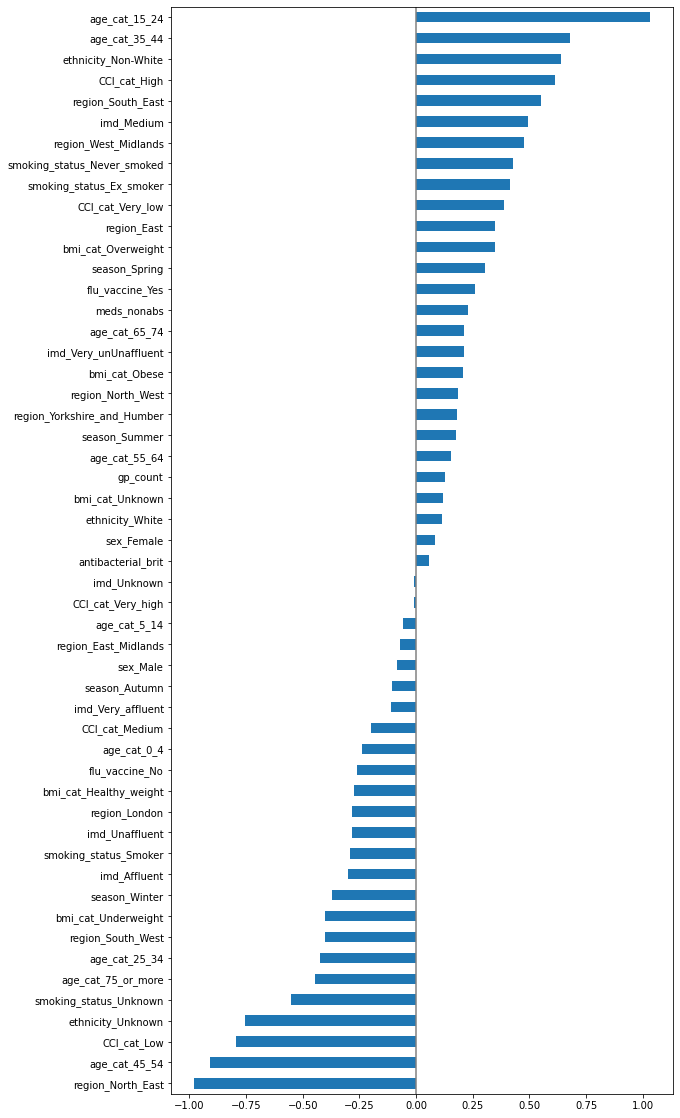

In [201]:
# set up coefficients of lr model
feature_names = lr_ot_externa_no_abs_incdt.feature_names_in_
coef = np.squeeze(lr_ot_externa_no_abs_incdt.coef_)
coef_lr = pd.DataFrame({'coefficients':coef}, index = feature_names)
coef_lr = coef_lr.coefficients.sort_values().reset_index()

# save coefficients
coef_lr.to_csv('../output/hospitalisation_prediction_ot_externa/coef_lr_ot_externa_no_abs_incdt.csv', index=False)

# obtain intercept
interc = lr_ot_externa_no_abs_incdt.intercept_
# save intercept
np.savetxt('../output/hospitalisation_prediction_ot_externa/intercept_ot_externa_no_abs_incdt.txt', interc, delimiter=',')

# plot coefficients 
coef_lr.plot(kind="barh", figsize=(9, 20))
# plt.title('Coefficients of LR model for incident hospital admission \n related to ot_externa with no antibiotics', fontsize=16)
plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/coef_lr_ot_externa_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

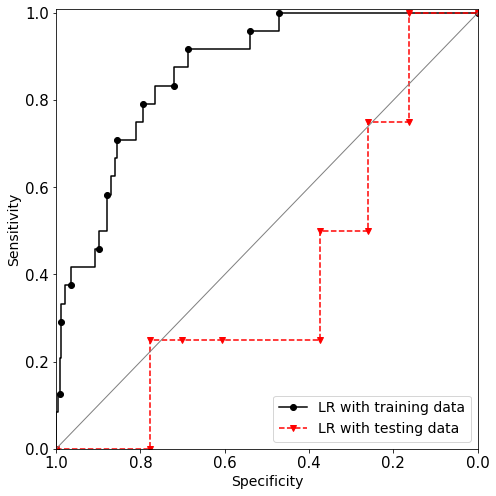

In [202]:
r_fpr1, r_tpr1, _ = roc_curve(data_ot_externa_no_abs_incdt_lr_y_train, pred_proba_ot_externa_no_abs_incdt_train[:,1])
r_fpr2, r_tpr2, _ = roc_curve(data_ot_externa_no_abs_incdt_lr_y_test, pred_proba_ot_externa_no_abs_incdt_test[:,1])

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')

squares = [0,1]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of LR for hospital admission related to incident \not_externa with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/roc_lr_ot_externa_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [ ]:
#predict probabilities
prob_pred_true_train = pd.DataFrame(data=pred_proba_ot_externa_no_abs_incdt_train[:,1])
prob_pred_true_train.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_ot_externa_no_abs_incdt_train.event_ot_externa_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_ot_externa_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin


#predict probabilities
prob_pred_true_test = pd.DataFrame(data=pred_proba_ot_externa_no_abs_incdt_test[:,1])
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_ot_externa_no_abs_incdt_test.event_ot_externa_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_ot_externa_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_ot_externa/calibration_lr_ot_externa_no_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_ot_externa/calibration_lr_ot_externa_no_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [205]:
# calculate AUROC and Brier score of lr model
r_auc1 = roc_auc_score(data_ot_externa_no_abs_incdt_lr_y_train, pred_proba_ot_externa_no_abs_incdt_train[:,1])
r_auc2 = roc_auc_score(data_ot_externa_no_abs_incdt_lr_y_test, pred_proba_ot_externa_no_abs_incdt_test[:,1])
brier1 = brier_score_loss(data_ot_externa_no_abs_incdt_lr_y_train, pred_proba_ot_externa_no_abs_incdt_train[:,1])
brier2 = brier_score_loss(data_ot_externa_no_abs_incdt_lr_y_test, pred_proba_ot_externa_no_abs_incdt_test[:,1])

# save model outputs
a = open("../output/hospitalisation_prediction_ot_externa/lr_ot_externa_no_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['AUROC of LR with training data of hospital admission related to incident ot_externa with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of LR with testing data of hospital admission related to incident ot_externa with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of LR with training data of hospital admission related to incident ot_externa with no antibiotics = %.4f' % (brier1),
              '\nBrier score of LR with testing data of hospital admission related to incident ot_externa with no antibiotics = %.4f' % (brier2)])

### 6-1-2- Incident hospital admission related to ot_externa with antibiotics

In [206]:
# encoding categorical data for LR
data = data_ot_externa_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']].reset_index()

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_ot_externa_abs_incdt_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_ot_externa_abs_incdt_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_ot_externa_abs_incdt_enc = data[['antibacterial_brit', 'gp_count']].join(data_ot_externa_abs_incdt_enc) #, 'gp_count', 'meds_nonabs', 'hx_hosp', 'event_ot_externa_admitted', 'duration_ot_externa_admitted'

data_ot_externa_abs_incdt_enc.head()

,antibacterial_brit,gp_count,meds_nonabs,age_cat_0_4,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_55_64,age_cat_5_14,...,ethnicity_Unknown,ethnicity_White,smoking_status_Ex_smoker,smoking_status_Never_smoked,smoking_status_Smoker,smoking_status_Unknown,season_Autumn,season_Spring,season_Summer,season_Winter
0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [207]:
#randomly splitting data into training (%75) and testing (%25)
data_ot_externa_abs_incdt_lr_X_train, data_ot_externa_abs_incdt_lr_X_test, data_ot_externa_abs_incdt_lr_y_train, data_ot_externa_abs_incdt_lr_y_test = train_test_split(data_ot_externa_abs_incdt_enc, data_ot_externa_abs_incdt.event_ot_externa_admitted, test_size=0.25, random_state=42)

print(f'shape of data_ot_externa_abs_incdt_lr_X for training: {data_ot_externa_abs_incdt_lr_X_train.shape}')
print(f'shape of data_ot_externa_abs_incdt_lr_X for testing: {data_ot_externa_abs_incdt_lr_X_test.shape}')
print(f'shape of data_ot_externa_abs_incdt_lr_y for training: {data_ot_externa_abs_incdt_lr_y_train.shape}')
print(f'shape of data_ot_externa_abs_incdt_lr_y for testing: {data_ot_externa_abs_incdt_lr_y_test.shape}')

shape of data_urti_abs_incdt_lr_X for training: (329, 52)
shape of data_urti_abs_incdt_lr_X for testing: (110, 52)
shape of data_urti_abs_incdt_lr_y for training: (329,)
shape of data_urti_abs_incdt_lr_y for testing: (110,)


In [208]:
#build LR model
lr_ot_externa_abs_incdt = LogisticRegression().fit(data_ot_externa_abs_incdt_lr_X_train, data_ot_externa_abs_incdt_lr_y_train)

#prediction of hsopital admission related to ot_externa of training data using lr
pred_proba_ot_externa_abs_incdt_train = lr_ot_externa_abs_incdt.predict_proba(data_ot_externa_abs_incdt_lr_X_train)
# pred_proba_ot_externa_abs_incdt_train

#calculate score of lr_ot_externa_abs_incdt with training data
lr_ot_externa_abs_incdt_training_score = lr_ot_externa_abs_incdt.score(data_ot_externa_abs_incdt_lr_X_train, data_ot_externa_abs_incdt_lr_y_train)
print(f'score of lr_ot_externa_abs_incdt with training data: {lr_ot_externa_abs_incdt_training_score}')

#prediction of hsopital admission related to ot_externa of testing data using lr
pred_proba_ot_externa_abs_incdt_test = lr_ot_externa_abs_incdt.predict_proba(data_ot_externa_abs_incdt_lr_X_test)
# pred_proba_ot_externa_abs_incdt_test

#calculate score of lr_ot_externa_abs_incdt with testing data
lr_ot_externa_abs_incdt_testing_score = lr_ot_externa_abs_incdt.score(data_ot_externa_abs_incdt_lr_X_test, data_ot_externa_abs_incdt_lr_y_test)
print(f'score of lr_ot_externa_abs_incdt with testing data: {lr_ot_externa_abs_incdt_testing_score}')

score of lr_urti_abs_incdt with training data: 0.9969604863221885
score of lr_urti_abs_incdt with testing data: 0.990909090909091


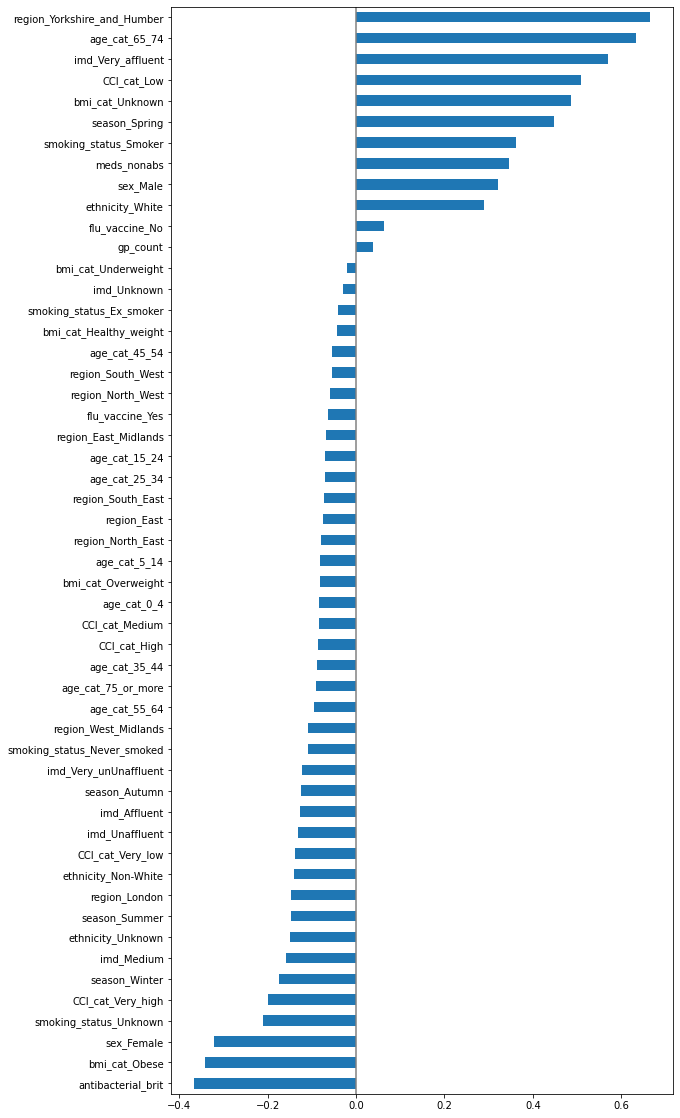

In [209]:
# set up coefficients of lr model
feature_names = lr_ot_externa_abs_incdt.feature_names_in_
coef = np.squeeze(lr_ot_externa_abs_incdt.coef_)
coef_lr = pd.DataFrame({'coefficients':coef}, index = feature_names)
coef_lr = coef_lr.coefficients.sort_values().reset_index()

# save coefficients
coef_lr.to_csv('../output/hospitalisation_prediction_ot_externa/coef_lr_ot_externa_abs_incdt.csv', index=False)

# obtain intercept
interc = lr_ot_externa_abs_incdt.intercept_
# save intercept
np.savetxt('../output/hospitalisation_prediction_ot_externa/intercept_ot_externa_abs_incdt.txt', interc, delimiter=',')

# plot coefficients
coef_lr.plot(kind="barh", figsize=(9, 20))
# plt.title('Coefficients of LR model for incident hospital admission \n related to ot_externa with antibiotics', fontsize=16)
plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/coef_lr_ot_externa_abs_incdt.jpg', bbox_inches='tight')
plt.show()

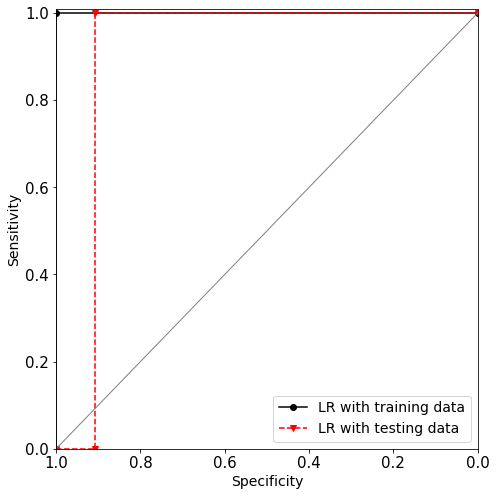

In [210]:
r_fpr1, r_tpr1, _ = roc_curve(data_ot_externa_abs_incdt_lr_y_train, pred_proba_ot_externa_abs_incdt_train[:,1])
r_fpr2, r_tpr2, _ = roc_curve(data_ot_externa_abs_incdt_lr_y_test, pred_proba_ot_externa_abs_incdt_test[:,1])

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')

squares = [0,1]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of LR for hospital admission related to incident \not_externa with antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/roc_lr_ot_externa_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [ ]:
#predict probabilities
prob_pred_true_train = pd.DataFrame(data=pred_proba_ot_externa_abs_incdt_train[:,1])
prob_pred_true_train.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_ot_externa_abs_incdt_train.event_ot_externa_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_ot_externa_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin


#predict probabilities
prob_pred_true_test = pd.DataFrame(data=pred_proba_ot_externa_abs_incdt_test[:,1])
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_ot_externa_abs_incdt_test.event_ot_externa_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_ot_externa_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_ot_externa/calibration_lr_ot_externa_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_ot_externa/calibration_lr_ot_externa_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [213]:
# calculate AUROC and Brier score of lr model
r_auc1 = roc_auc_score(data_ot_externa_abs_incdt_lr_y_train, pred_proba_ot_externa_abs_incdt_train[:,1])
r_auc2 = roc_auc_score(data_ot_externa_abs_incdt_lr_y_test, pred_proba_ot_externa_abs_incdt_test[:,1])
brier1 = brier_score_loss(data_ot_externa_abs_incdt_lr_y_train, pred_proba_ot_externa_abs_incdt_train[:,1])
brier2 = brier_score_loss(data_ot_externa_abs_incdt_lr_y_test, pred_proba_ot_externa_abs_incdt_test[:,1])

# save model outputs
a = open("../output/hospitalisation_prediction_ot_externa/lr_ot_externa_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['AUROC of LR with training data of hospital admission related to incident ot_externa with antibiotics = %.4f' % (r_auc1),
              '\nAUROC of LR with testing data of hospital admission related to incident ot_externa with antibiotics = %.4f' % (r_auc2),
              '\nBrier score of LR with training data of hospital admission related to incident ot_externa with antibiotics = %.4f' % (brier1),
              '\nBrier score of LR with testing data of hospital admission related to incident ot_externa with antibiotics = %.4f' % (brier2)])

### 6-1-3- Prevalent hospital admission related to ot_externa with no antibiotics

In [214]:
# encoding categorical data for LR
data = data_ot_externa_no_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']].reset_index()

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_ot_externa_no_abs_prevl_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_ot_externa_no_abs_prevl_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_ot_externa_no_abs_prevl_enc = data[['antibacterial_brit', 'gp_count']].join(data_ot_externa_no_abs_prevl_enc) #, 'gp_count', 'meds_nonabs', 'hx_hosp', 'event_ot_externa_admitted', 'duration_ot_externa_admitted'

data_ot_externa_no_abs_prevl_enc.head()

,antibacterial_brit,gp_count,meds_nonabs,age_cat_0_4,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_55_64,age_cat_5_14,...,ethnicity_Unknown,ethnicity_White,smoking_status_Ex_smoker,smoking_status_Never_smoked,smoking_status_Smoker,smoking_status_Unknown,season_Autumn,season_Spring,season_Summer,season_Winter
0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.0,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [215]:
#randomly splitting data into training (%75) and testing (%25)
data_ot_externa_no_abs_prevl_lr_X_train, data_ot_externa_no_abs_prevl_lr_X_test, data_ot_externa_no_abs_prevl_lr_y_train, data_ot_externa_no_abs_prevl_lr_y_test = train_test_split(data_ot_externa_no_abs_prevl_enc, data_ot_externa_no_abs_prevl.event_ot_externa_admitted, test_size=0.25, random_state=42)

print(f'shape of data_ot_externa_no_abs_prevl_lr_X for training: {data_ot_externa_no_abs_prevl_lr_X_train.shape}')
print(f'shape of data_ot_externa_no_abs_prevl_lr_X for testing: {data_ot_externa_no_abs_prevl_lr_X_test.shape}')
print(f'shape of data_ot_externa_no_abs_prevl_lr_y for training: {data_ot_externa_no_abs_prevl_lr_y_train.shape}')
print(f'shape of data_ot_externa_no_abs_prevl_lr_y for testing: {data_ot_externa_no_abs_prevl_lr_y_test.shape}')

shape of data_urti_no_abs_prevl_lr_X for training: (309, 52)
shape of data_urti_no_abs_prevl_lr_X for testing: (104, 52)
shape of data_urti_no_abs_prevl_lr_y for training: (309,)
shape of data_urti_no_abs_prevl_lr_y for testing: (104,)


In [216]:
#build LR model
lr_ot_externa_no_abs_prevl = LogisticRegression().fit(data_ot_externa_no_abs_prevl_lr_X_train, data_ot_externa_no_abs_prevl_lr_y_train)

#prediction of hsopital admission related to ot_externa of training data using lr
pred_proba_ot_externa_no_abs_prevl_train = lr_ot_externa_no_abs_prevl.predict_proba(data_ot_externa_no_abs_prevl_lr_X_train)
# pred_proba_ot_externa_no_abs_prevl_train

#calculate score of lr_ot_externa_no_abs_prevl with training data
lr_ot_externa_no_abs_prevl_training_score = lr_ot_externa_no_abs_prevl.score(data_ot_externa_no_abs_prevl_lr_X_train, data_ot_externa_no_abs_prevl_lr_y_train)
print(f'score of lr_ot_externa_no_abs_prevl with training data: {lr_ot_externa_no_abs_prevl_training_score}')

#prediction of hsopital admission related to ot_externa of testing data using lr
pred_proba_ot_externa_no_abs_prevl_test = lr_ot_externa_no_abs_prevl.predict_proba(data_ot_externa_no_abs_prevl_lr_X_test)
# pred_proba_ot_externa_no_abs_prevl_test

#calculate score of lr_ot_externa_no_abs_prevl with testing data
lr_ot_externa_no_abs_prevl_testing_score = lr_ot_externa_no_abs_prevl.score(data_ot_externa_no_abs_prevl_lr_X_test, data_ot_externa_no_abs_prevl_lr_y_test)
print(f'score of lr_ot_externa_no_abs_prevl with testing data: {lr_ot_externa_no_abs_prevl_testing_score}')

score of lr_urti_no_abs_prevl with training data: 0.9902912621359223
score of lr_urti_no_abs_prevl with testing data: 0.9903846153846154


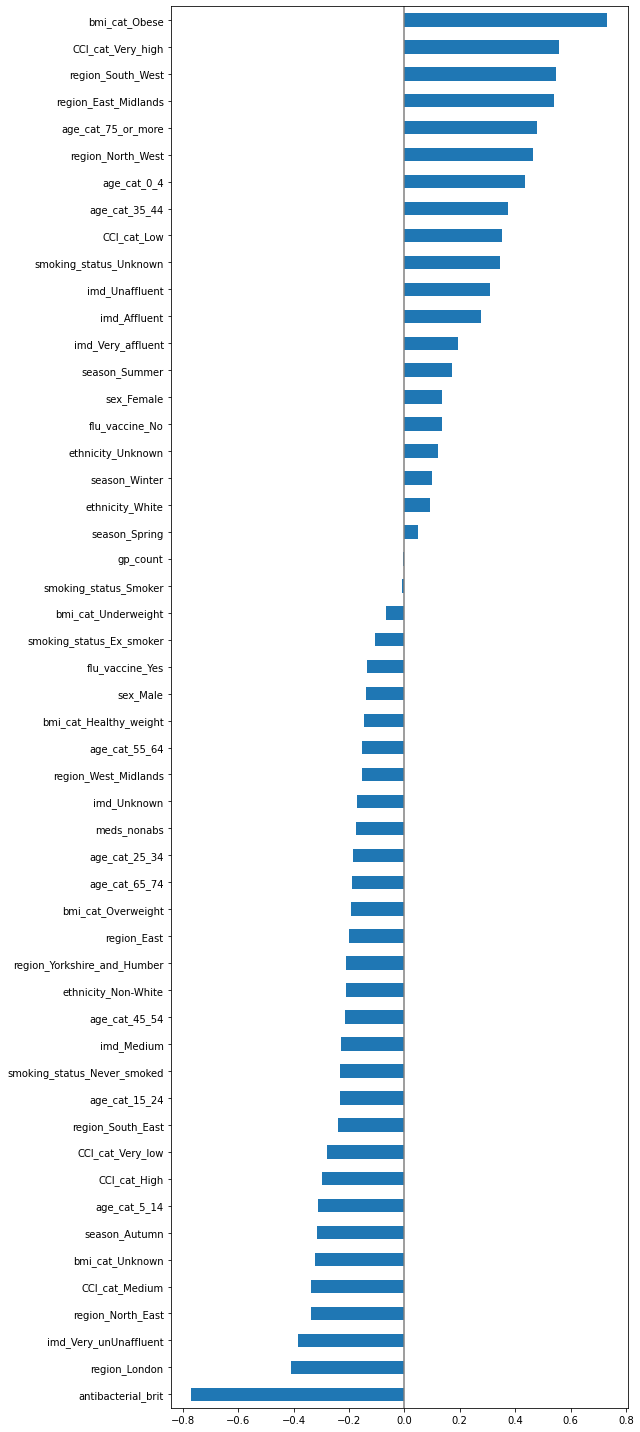

In [217]:
# set up coefficients of lr model
feature_names = lr_ot_externa_no_abs_prevl.feature_names_in_
coef = np.squeeze(lr_ot_externa_no_abs_prevl.coef_)
coef_lr = pd.DataFrame({'coefficients':coef}, index = feature_names)
coef_lr = coef_lr.coefficients.sort_values().reset_index()

# save coefficients
coef_lr.to_csv('../output/hospitalisation_prediction_ot_externa/coef_lr_ot_externa_no_abs_prevl.csv', index=False)

# obtain intercept
interc = lr_ot_externa_no_abs_prevl.intercept_
# save intercept
np.savetxt('../output/hospitalisation_prediction_ot_externa/intercept_ot_externa_no_abs_prevl.txt', interc, delimiter=',')

# plot coefficients
coef_lr.plot(kind="barh", figsize=(9, 20))
# plt.title('Coefficients of LR model for prevalent hospital admission \n related to ot_externa with no antibiotics', fontsize=16)
plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/coef_lr_ot_externa_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()


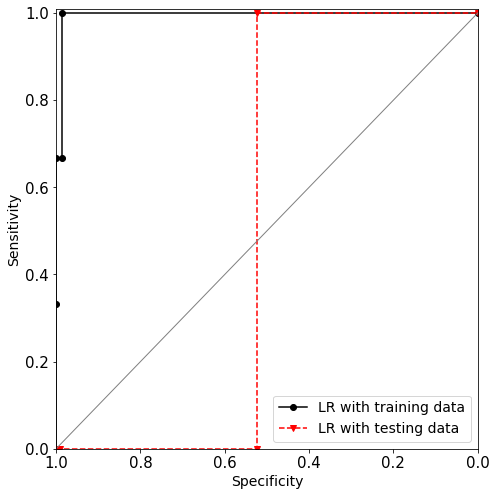

In [218]:
r_fpr1, r_tpr1, _ = roc_curve(data_ot_externa_no_abs_prevl_lr_y_train, pred_proba_ot_externa_no_abs_prevl_train[:,1])
r_fpr2, r_tpr2, _ = roc_curve(data_ot_externa_no_abs_prevl_lr_y_test, pred_proba_ot_externa_no_abs_prevl_test[:,1])

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')

squares = [0,1]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of LR for hospital admission related to prevalent \not_externa with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/roc_lr_ot_externa_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [ ]:
#predict probabilities
prob_pred_true_train = pd.DataFrame(data=pred_proba_ot_externa_no_abs_prevl_train[:,1])
prob_pred_true_train.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_ot_externa_no_abs_prevl_train.event_ot_externa_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_ot_externa_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin


#predict probabilities
prob_pred_true_test = pd.DataFrame(data=pred_proba_ot_externa_no_abs_prevl_test[:,1])
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_ot_externa_no_abs_prevl_test.event_ot_externa_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_ot_externa_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_ot_externa/calibration_lr_ot_externa_no_abs_prevl_train.jpg', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_ot_externa/calibration_lr_ot_externa_no_abs_prevl_test.jpg', bbox_inches='tight')
plt.show()

In [221]:
# calculate AUROC and Brier score of lr model
r_auc1 = roc_auc_score(data_ot_externa_no_abs_prevl_lr_y_train, pred_proba_ot_externa_no_abs_prevl_train[:,1])
r_auc2 = roc_auc_score(data_ot_externa_no_abs_prevl_lr_y_test, pred_proba_ot_externa_no_abs_prevl_test[:,1])
brier1 = brier_score_loss(data_ot_externa_no_abs_prevl_lr_y_train, pred_proba_ot_externa_no_abs_prevl_train[:,1])
brier2 = brier_score_loss(data_ot_externa_no_abs_prevl_lr_y_test, pred_proba_ot_externa_no_abs_prevl_test[:,1])

# save model outputs
a = open("../output/hospitalisation_prediction_ot_externa/lr_ot_externa_no_abs_prevl_output.txt", "w")
a.write("")
a.writelines(['AUROC of LR with training data of hospital admission related to prevalent ot_externa with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of LR with testing data of hospital admission related to prevalent ot_externa with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of LR with training data of hospital admission related to prevalent ot_externa with no antibiotics = %.4f' % (brier1),
              '\nBrier score of LR with testing data of hospital admission related to prevalent ot_externa with no antibiotics = %.4f' % (brier2)])

### 6-1-4- Prevalent hospital admission related to ot_externa with antibiotics

In [ ]:
# encoding categorical data for LR
data = data_ot_externa_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']].reset_index()

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
data_ot_externa_abs_prevl_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
data_ot_externa_abs_prevl_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
data_ot_externa_abs_prevl_enc = data[['antibacterial_brit', 'gp_count']].join(data_ot_externa_abs_prevl_enc) #, 'gp_count', 'meds_nonabs', 'hx_hosp', 'event_ot_externa_admitted', 'duration_ot_externa_admitted'

data_ot_externa_abs_prevl_enc.head()

In [ ]:
#randomly splitting data into training (%75) and testing (%25)
data_ot_externa_abs_prevl_lr_X_train, data_ot_externa_abs_prevl_lr_X_test, data_ot_externa_abs_prevl_lr_y_train, data_ot_externa_abs_prevl_lr_y_test = train_test_split(data_ot_externa_abs_prevl_enc, data_ot_externa_abs_prevl.event_ot_externa_admitted, test_size=0.25, random_state=42)

print(f'shape of data_ot_externa_abs_prevl_lr_X for training: {data_ot_externa_abs_prevl_lr_X_train.shape}')
print(f'shape of data_ot_externa_abs_prevl_lr_X for testing: {data_ot_externa_abs_prevl_lr_X_test.shape}')
print(f'shape of data_ot_externa_abs_prevl_lr_y for training: {data_ot_externa_abs_prevl_lr_y_train.shape}')
print(f'shape of data_ot_externa_abs_prevl_lr_y for testing: {data_ot_externa_abs_prevl_lr_y_test.shape}')

In [ ]:
#build LR model
lr_ot_externa_abs_prevl = LogisticRegression().fit(data_ot_externa_abs_prevl_lr_X_train, data_ot_externa_abs_prevl_lr_y_train)

#prediction of hsopital admission related to ot_externa of training data using lr
pred_proba_ot_externa_abs_prevl_train = lr_ot_externa_abs_prevl.predict_proba(data_ot_externa_abs_prevl_lr_X_train)
# pred_proba_ot_externa_abs_prevl_train

#calculate score of lr_ot_externa_abs_prevl with training data
lr_ot_externa_abs_prevl_training_score = lr_ot_externa_abs_prevl.score(data_ot_externa_abs_prevl_lr_X_train, data_ot_externa_abs_prevl_lr_y_train)
print(f'score of lr_ot_externa_abs_prevl with training data: {lr_ot_externa_abs_prevl_training_score}')

#prediction of hsopital admission related to ot_externa of testing data using lr
pred_proba_ot_externa_abs_prevl_test = lr_ot_externa_abs_prevl.predict_proba(data_ot_externa_abs_prevl_lr_X_test)
# pred_proba_ot_externa_abs_prevl_test

#calculate score of lr_ot_externa_abs_prevl with testing data
lr_ot_externa_abs_prevl_testing_score = lr_ot_externa_abs_prevl.score(data_ot_externa_abs_prevl_lr_X_test, data_ot_externa_abs_prevl_lr_y_test)
print(f'score of lr_ot_externa_abs_prevl with testing data: {lr_ot_externa_abs_prevl_testing_score}')

In [ ]:
# set up coefficients of lr model
feature_names = lr_ot_externa_abs_prevl.feature_names_in_
coef = np.squeeze(lr_ot_externa_abs_prevl.coef_)
coef_lr = pd.DataFrame({'coefficients':coef}, index = feature_names)
coef_lr = coef_lr.coefficients.sort_values().reset_index()

# save coefficients
coef_lr.to_csv('../output/hospitalisation_prediction_ot_externa/coef_lr_ot_externa_abs_prevl.csv', index=False)

# obtain intercept
interc = lr_ot_externa_abs_prevl.intercept_
# save intercept
np.savetxt('../output/hospitalisation_prediction_ot_externa/intercept_ot_externa_abs_prevl.txt', interc, delimiter=',')

# plot coefficients
coef_lr.plot(kind="barh", figsize=(9, 20))
# plt.title('Coefficients of LR model for incident hospital admission \n related to ot_externa with antibiotics', fontsize=16)
plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/coef_lr_ot_externa_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [ ]:
r_fpr1, r_tpr1, _ = roc_curve(data_ot_externa_abs_prevl_lr_y_train, pred_proba_ot_externa_abs_prevl_train[:,1])
r_fpr2, r_tpr2, _ = roc_curve(data_ot_externa_abs_prevl_lr_y_test, pred_proba_ot_externa_abs_prevl_test[:,1])

fig, ax1 = pyplot.subplots(figsize=(7, 7))
line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')

squares = [0,1]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of LR for hospital admission related to incident \not_externa with antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/roc_lr_ot_externa_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [ ]:
#predict probabilities
prob_pred_true_train = pd.DataFrame(data=pred_proba_ot_externa_abs_prevl_train[:,1])
prob_pred_true_train.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_train = pd.merge(prob_pred_true_train, data_ot_externa_abs_prevl_train.event_ot_externa_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_ot_externa_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
# prob_pred_true_train_groupby_bin


#predict probabilities
prob_pred_true_test = pd.DataFrame(data=pred_proba_ot_externa_abs_prevl_test[:,1])
prob_pred_true_test.columns = ['pred']

#group cumulative hazard into 10 bins with equal frequency of observations in each bin
prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

#merge cumulative hazards with their actual events (0, 1)
prob_pred_true_test = pd.merge(prob_pred_true_test, data_ot_externa_abs_prevl_test.event_ot_externa_admitted, left_index=True, right_index=True)

#groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_ot_externa_admitted']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

#calculate proportion of events in each bin
prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
# prob_pred_true_test_groupby_bin

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_ot_externa/calibration_lr_ot_externa_abs_prevl_train.jpg', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
plt.xlabel('Mean predicted probabilities', fontsize=14)
plt.ylabel('Proportion of observed values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
# plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
plt.savefig('../output/hospitalisation_prediction_ot_externa/calibration_lr_ot_externa_abs_prevl_test.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# calculate AUROC and Brier score of lr model
r_auc1 = roc_auc_score(data_ot_externa_abs_prevl_lr_y_train, pred_proba_ot_externa_abs_prevl_train[:,1])
r_auc2 = roc_auc_score(data_ot_externa_abs_prevl_lr_y_test, pred_proba_ot_externa_abs_prevl_test[:,1])
brier1 = brier_score_loss(data_ot_externa_abs_prevl_lr_y_train, pred_proba_ot_externa_abs_prevl_train[:,1])
brier2 = brier_score_loss(data_ot_externa_abs_prevl_lr_y_test, pred_proba_ot_externa_abs_prevl_test[:,1])

# save model outputs
a = open("../output/hospitalisation_prediction_ot_externa/lr_ot_externa_abs_prevl_output.txt", "w")
a.write("")
a.writelines(['AUROC of LR with training data of hospital admission related to prevalent ot_externa with antibiotics = %.4f' % (r_auc1),
              '\nAUROC of LR with testing data of hospital admission related to prevalent ot_externa with antibiotics = %.4f' % (r_auc2),
              '\nBrier score of LR with training data of hospital admission related to prevalent ot_externa with antibiotics = %.4f' % (brier1),
              '\nBrier score of LR with testing data of hospital admission related to prevalent ot_externa with antibiotics = %.4f' % (brier2)])